In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans
from dtaidistance import dtw, clustering
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform
from scipy.stats import zscore
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score
from clustering_utils import *

c:\Users\nick_\Anaconda3\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
data = pd.read_csv('clustering_data.csv', index_col=[0])
data

ID  egfr  times
0         0  69.0      0
1         0  62.0    449
2         0  56.0    579
3         0  62.0    716
4         0  50.0    891
...     ...   ...    ...
10409  1369  36.0    689
10410  1369  40.0    820
10413  1371   5.0      0
10414  1371  32.0    137
10415  1371  37.0    147

[10173 rows x 3 columns]

# Let's try using k-Means clustering using DTW as a metric

## Demonstration using 15 different time series

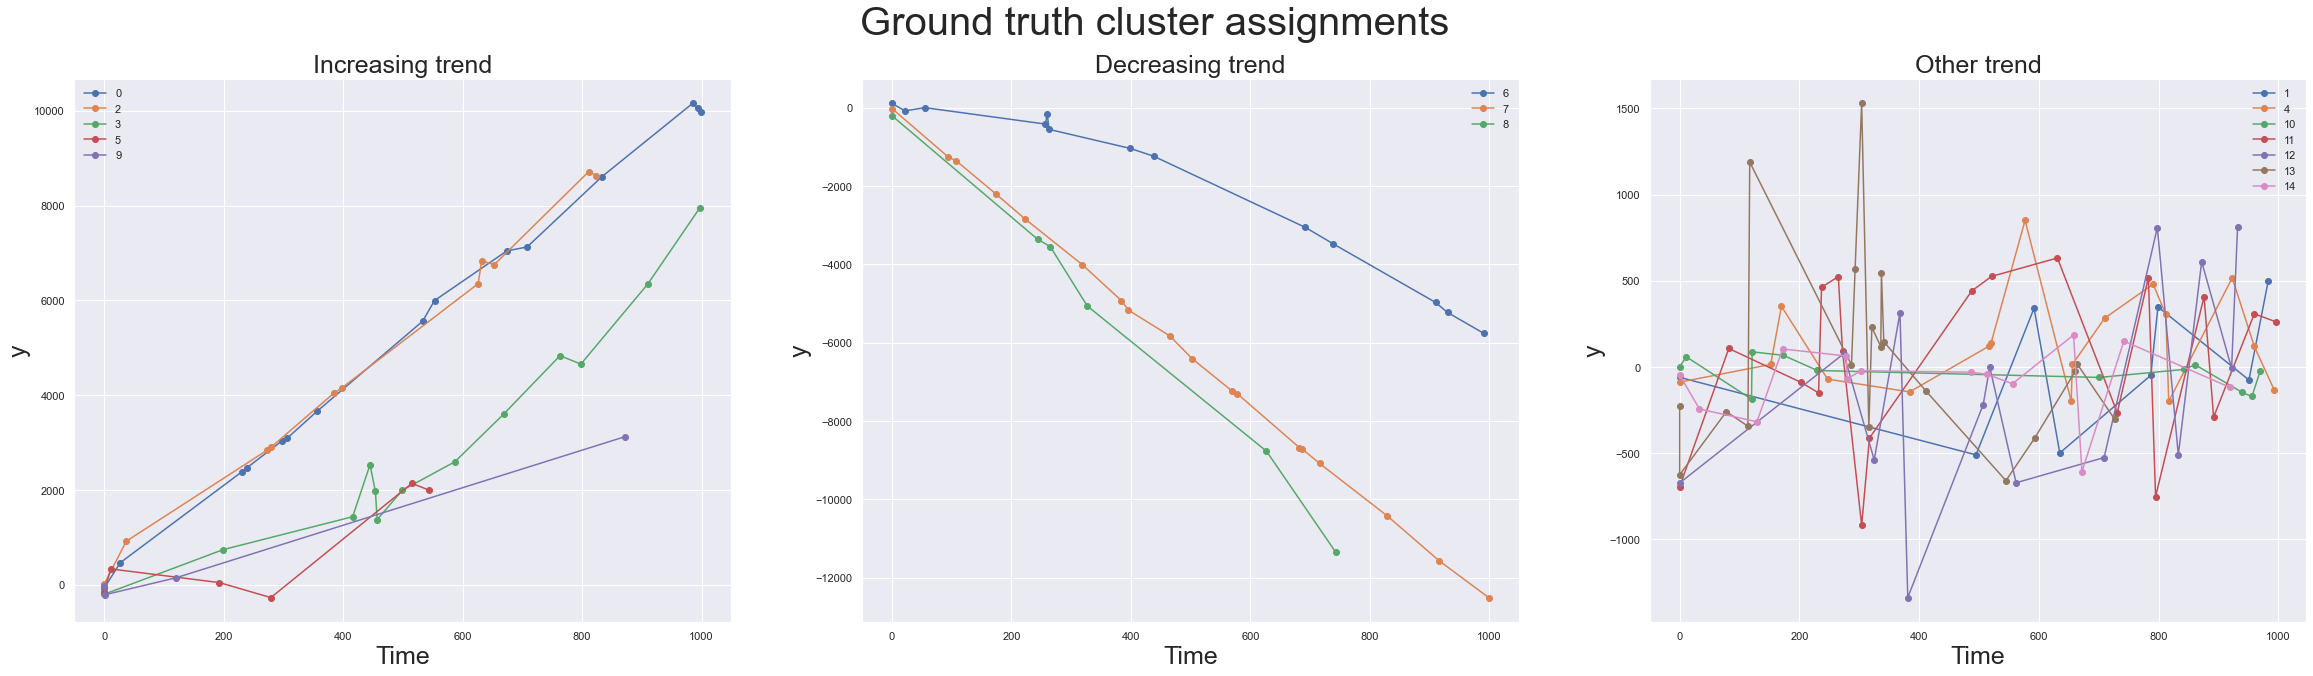

In [3]:
# Define the data generating functions
linear_trend = lambda t, noise , coef: coef * t + 3 + noise * np.random.randn(t.shape[0])
quadr_trend = lambda t, noise, coef: coef * t**2 + noise * np.random.randn(t.shape[0])
random = lambda t, noise: noise * np.ones_like(t) * np.random.randn(t.shape[0])

funcs = {'linear' : linear_trend, 'quadratic' : quadr_trend, 'random' : random}
sampled_times , y_series , labels = generate_ts_data(funcs, n_ts=15, rand_seed=1)
#y_series = [exponential_smoothing(series, alpha=0.30) for series in y_series]
plot_data(sampled_times, y_series, labels)

In [8]:
labels_dict = {2 : 'increasing', 1 : 'decreasing', 0 : 'other'}

X = to_time_series_dataset(y_series)
km = TimeSeriesKMeans(n_clusters=3,
                           metric="dtw",
                           n_init=3,
                           verbose=False,
                           random_state=1, 
                           n_jobs=-1)
l = km.fit_predict(X)
acc = rand_score(labels, l)
print(f'Rand Index score: {acc :.3f}')

Rand Index score: 0.810


## Observations:
1. For the 'Increasing' cluster (label 2 in the kMeans prediction), we can see that according to the assigned clusters the red and purple (no. 5 and 9) lines were assigned to the 'Random' cluster.
2. For the 'Decreasing' cluster (label 1 in the kMeans prediction), we can see that all time series were correctly clustered. 
3. Finally, for the 'Random' cluster (label 0 in the kMeans prediction), all random time series were clustered correctly.

## Let's try with 50 different time series

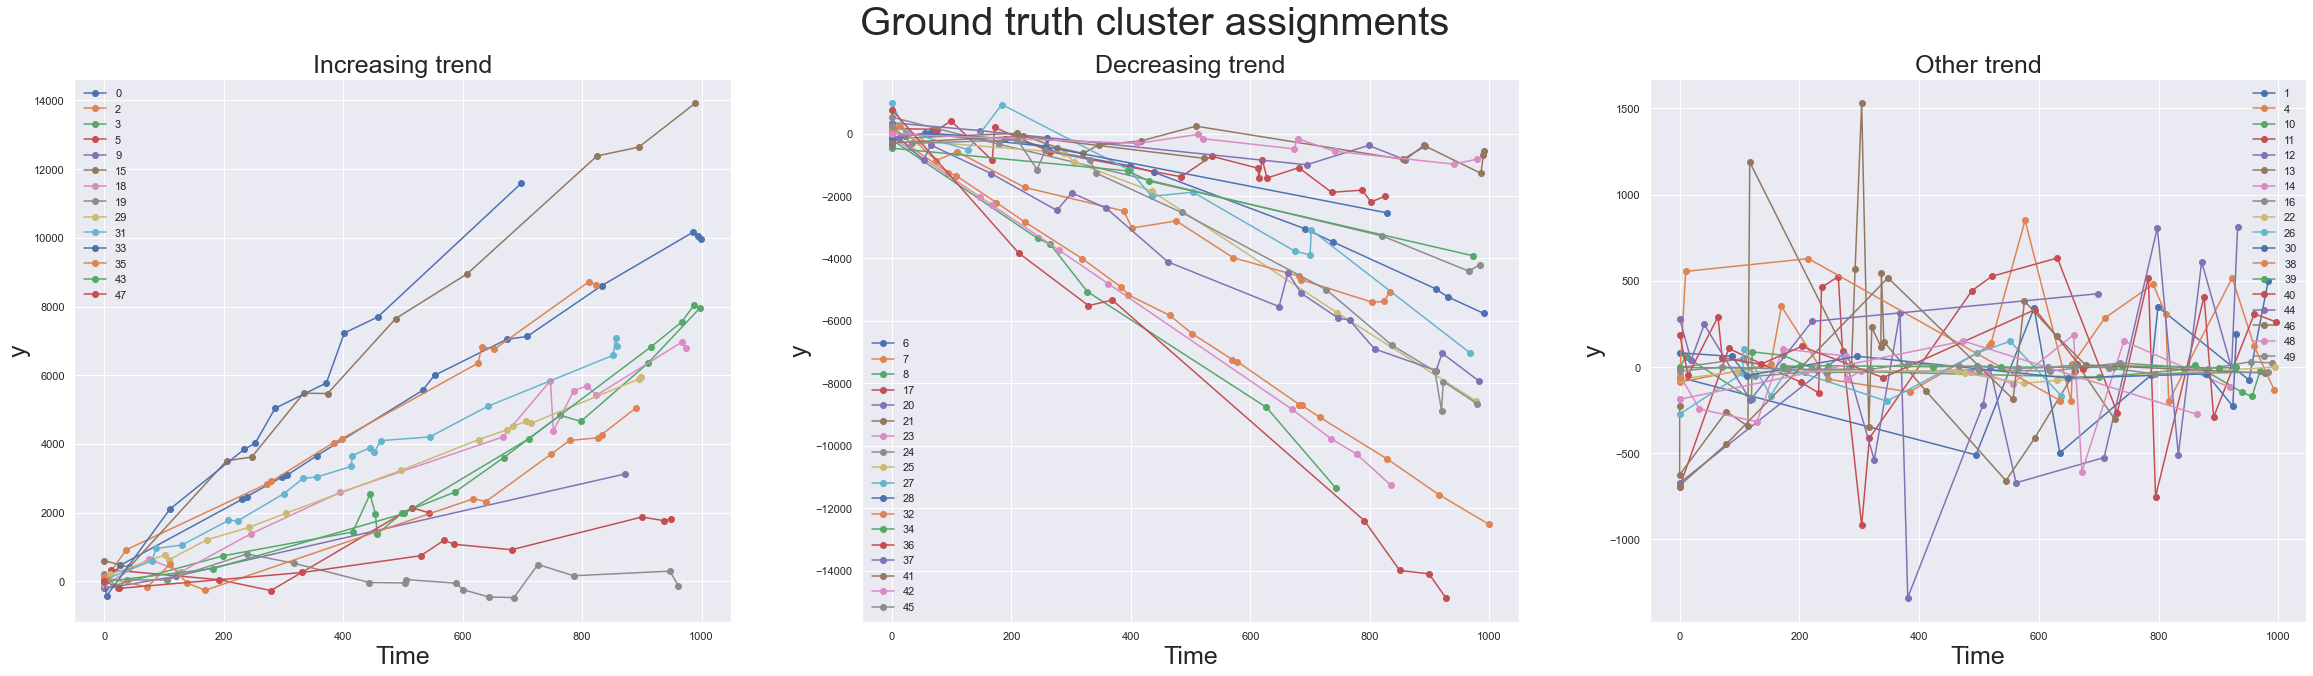

In [64]:
sampled_times2 , y_series2 , labels2 = generate_ts_data(funcs, n_ts=50, rand_seed=1)
#y_series2 = [exponential_smoothing(series, alpha=0.30) for series in y_series2]

plot_data(sampled_times2, y_series2, labels2)

In [10]:
X = to_time_series_dataset(y_series2)
km = TimeSeriesKMeans(n_clusters=3,
                           metric="dtw",
                           n_init=3,
                           verbose=False,
                           random_state=1, 
                           n_jobs=-1)
l = km.fit_predict(X)
labels_dict = {2 : 'increasing', 1 : 'decreasing', 0 : 'other'}
acc = rand_score(labels2, l)
print(f'Rand Index score: {acc :.3f}')

Rand Index score: 0.700


No handles with labels found to put in legend.


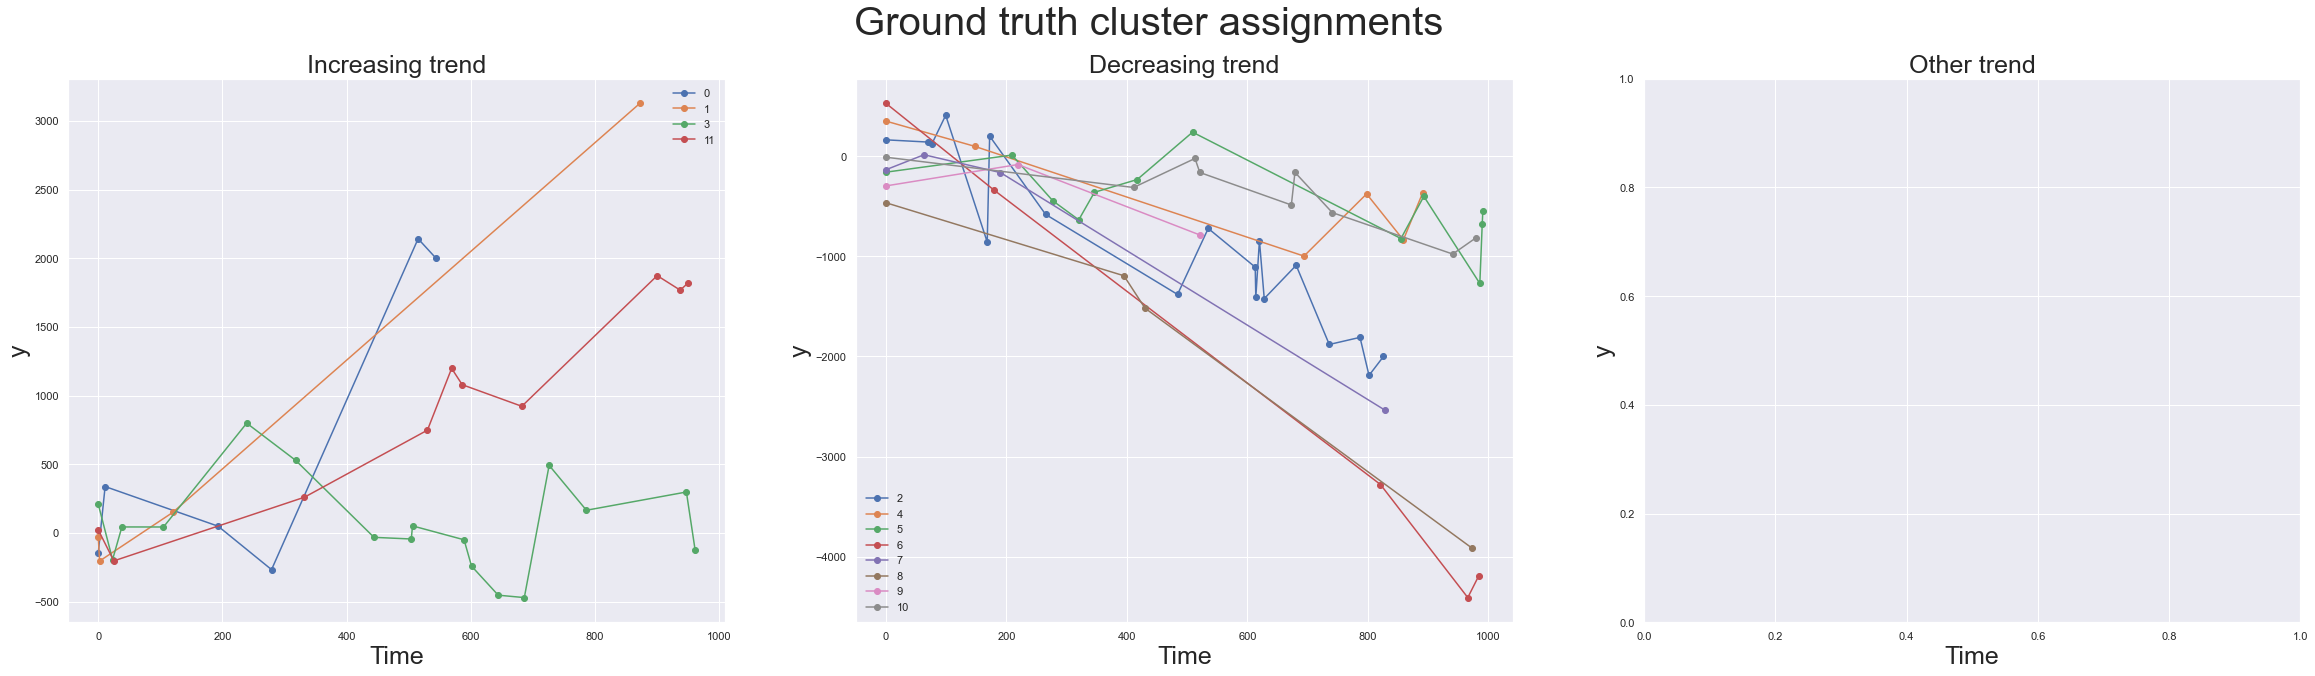

In [11]:
# Visualize the time series that were incorrectly clustered
wrong_assignments = np.vectorize(labels_dict.get)(l) != labels2
wrong_assignments_ind = np.where(wrong_assignments)[0]
times_wrong, y_series_wrong, labels_wrong = [sampled_times2[index] for index in wrong_assignments_ind] , [y_series2[index] for index in wrong_assignments_ind] , labels2[wrong_assignments_ind]
# Let's plot them
plot_data(times_wrong, y_series_wrong, labels_wrong);

## Observations 

We see that amongst the incorrectly clustered time series, a lot of them have their true underlying trends distorted by a large amount of noise, have very few datapoints or their structures are highly irregular. 

# K-Medoids clustering using DTW

## Demonstration using 15 different time series

In [15]:
model = clustering.KMedoids(dists_fun=dtw.distance_matrix_fast, k=3, dists_options={})
cluster_idx = model.fit(y_series)
medoid_labels = [0, 2, 0, 0, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2]
cluster_idx

{2: {0, 2, 3}, 14: {1, 4, 5, 9, 10, 11, 12, 13, 14}, 8: {6, 7, 8}}

In [16]:
acc = rand_score(labels, medoid_labels)
print(f'Rand Index score: {acc :.3f}')

Rand Index score: 0.810


Clusters are the same as with k-Means

## Let's try with 50 different time series

In [52]:
model = clustering.KMedoids(dists_fun=dtw.distance_matrix_fast, k=3, dists_options={})
cluster_idx = model.fit(y_series2)
medoid_labels2 = np.array([0., 2., 0., 0., 2., 2., 1., 1., 1., 2., 2., 2., 2., 2., 2., 0., 2.,
                           2., 0., 2., 2., 2., 2., 1., 1., 1., 2., 1., 2., 0., 2., 0., 1., 0.,
                           2., 0., 1., 1., 2., 2., 2., 2., 2., 0., 2., 1., 2., 2., 2., 2.])
                           
cluster_idx

{3: {0, 2, 3, 15, 18, 29, 31, 33, 35, 43},
 26: {1,
  4,
  5,
  9,
  10,
  11,
  12,
  13,
  14,
  16,
  17,
  19,
  20,
  21,
  22,
  26,
  28,
  30,
  34,
  38,
  39,
  40,
  41,
  42,
  44,
  46,
  47,
  48,
  49},
 25: {6, 7, 8, 23, 24, 25, 27, 32, 36, 37, 45}}

In [56]:
acc = rand_score(labels2, medoid_labels2)
print(f'Rand Index score: {acc :.3f}')

Rand Index score: 0.720


The results are slightly better compared to those produced by k-Means.

# Agglomerative Clustering

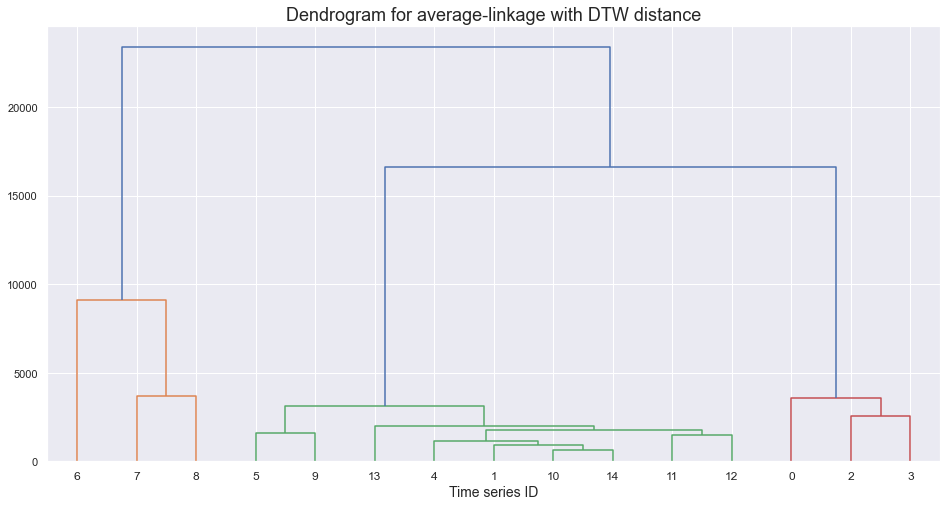

In [57]:
distance_matrix = dtw.distance_matrix_fast(y_series)
condensed_dist_matrix = squareform(distance_matrix)
linkage_matrix = hierarchical_clustering(condensed_dist_matrix, method='average')

In [58]:
# select maximum number of clusters
cluster_labels = fcluster(linkage_matrix, t=3, criterion='maxclust')
cluster_labels

array([3, 2, 3, 3, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2], dtype=int32)

In [59]:
acc = rand_score(labels, cluster_labels)
print(f'Rand Index score: {acc :.3f}')

Rand Index score: 0.810


## Let's see what happens using 50 time series

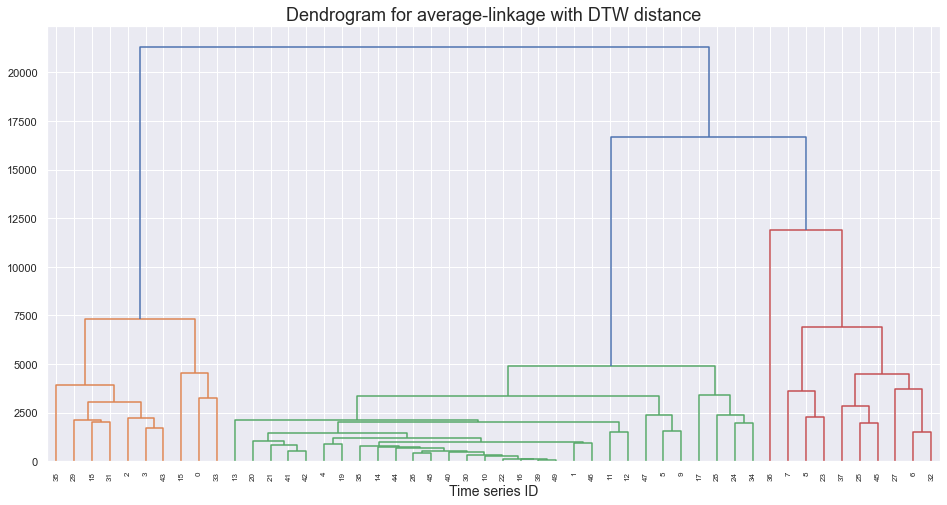

In [60]:
distance_matrix2 = dtw.distance_matrix_fast(y_series2)
condensed_dist_matrix2 = squareform(distance_matrix2)
linkage_matrix2 = hierarchical_clustering(condensed_dist_matrix2, method='average')

In [61]:
cluster_labels2 = fcluster(linkage_matrix2, t=3, criterion='maxclust')
cluster_labels2

array([1, 2, 1, 1, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2,
       2, 3, 2, 3, 2, 3, 2, 1, 2, 1, 3, 1, 2, 1, 3, 3, 2, 2, 2, 2, 2, 1,
       2, 3, 2, 2, 2, 2], dtype=int32)

In [62]:
acc = rand_score(labels2, cluster_labels2)
print(f'Rand Index score: {acc :.3f}')

Rand Index score: 0.700


Results are again very similar compared to the previous two methods.

## Let's now use these clustering techniques on the actual dataset

### Use a subset of the data first to interpret results

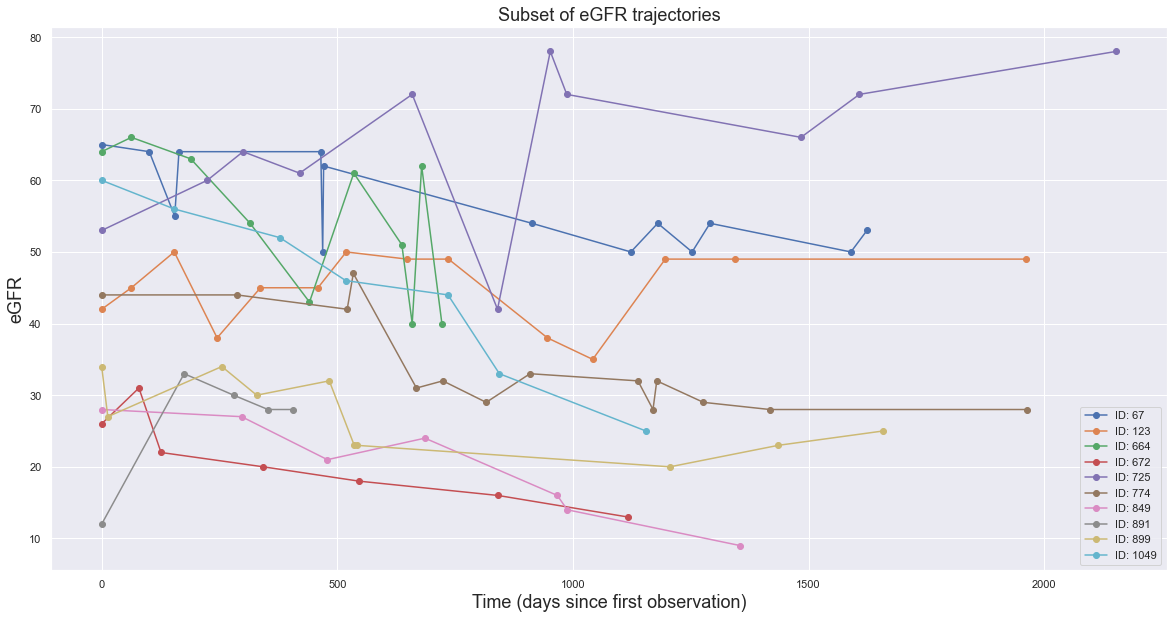

In [26]:
np.random.seed(10)
n_groups = np.unique(data['ID'].values).shape[0]
subset_size = 10
rand_subset = np.random.choice(a=n_groups, size=subset_size, replace=False)
data_subset = data[data['ID'].isin(rand_subset)]

patient_traj_subset = [] # store the individual patient trajectories in the form of (id, time_vals, egfr_vals)

for id in np.unique(data_subset['ID'].values):
    egfr = data[data['ID'] == id][['egfr']] # individual patient egfr values
    time = data[data['ID'] == id][['times']]
    id_ts = (id, time, egfr)
    patient_traj_subset.append(id_ts)

id_subset , time_series_subset, egfr_series_subset = [ts[0] for ts in patient_traj_subset] , [ts[1] for ts in patient_traj_subset], [ts[2] for ts in patient_traj_subset]

plt.figure(figsize=(20, 10))
for i in range(len(id_subset)):
    plt.plot(time_series_subset[i], egfr_series_subset[i], '-o', label=f'ID: {id_subset[i]}')
    plt.xlabel('Time (days since first observation)', size=18)
    plt.ylabel('eGFR', size=18)
    plt.legend()
    plt.title('Subset of eGFR trajectories', fontsize=18);

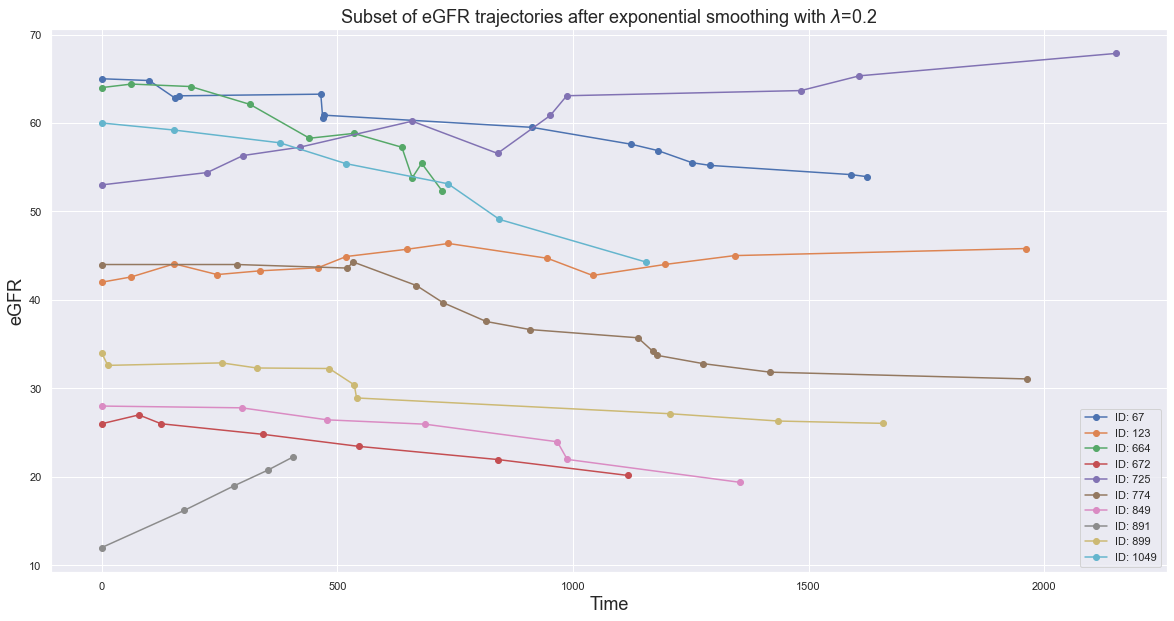

In [27]:
# Let's try to use exponential smoothing on the series
smoothing_factor = 0.2
egfr_series_subset_smoothed = [exponential_smoothing(ts['egfr'].values , alpha=smoothing_factor) for ts in egfr_series_subset]

plt.figure(figsize=(20, 10))
for i in range(len(id_subset)):
    plt.plot(time_series_subset[i], egfr_series_subset_smoothed[i], '-o', label=f'ID: {id_subset[i]}')
    plt.xlabel('Time', size=18)
    plt.ylabel('eGFR', size=18)
    plt.legend()
    plt.title(f'Subset of eGFR trajectories after exponential smoothing with $\lambda$={smoothing_factor}', fontsize=18);

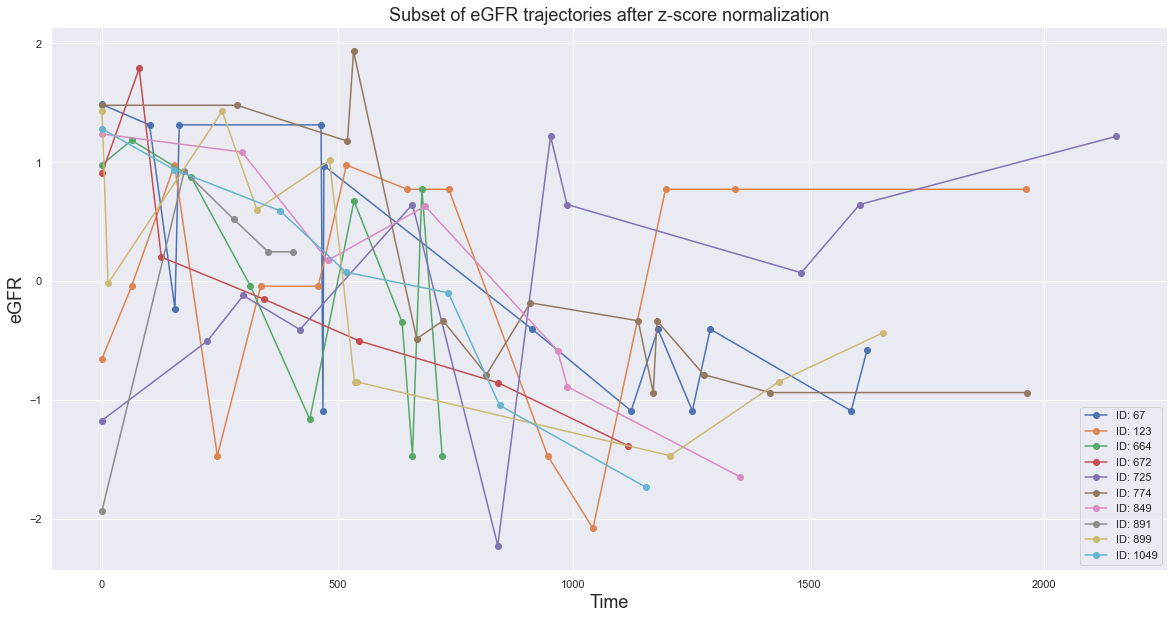

In [28]:
# Let's try to normialize the series using z-scores
egfr_series_subset_normalized = [zscore(ts['egfr'].values) for ts in egfr_series_subset]

plt.figure(figsize=(20, 10))
for i in range(len(id_subset)):
    plt.plot(time_series_subset[i], egfr_series_subset_normalized[i], '-o', label=f'ID: {id_subset[i]}')
    plt.xlabel('Time', size=18)
    plt.ylabel('eGFR', size=18)
    plt.legend()
    plt.title('Subset of eGFR trajectories after z-score normalization', fontsize=18);

### Exponential smoothing seems to be a more reasonable transformation for purposes of trend identification.

# Let's try the above clustering techniques on the actual dataset and compare them

In [29]:
patient_traj = [] # store the individual patient trajectories in the form of (id, time_vals, egfr_vals)

for id in np.unique(data['ID'].values):
    egfr = data[data['ID'] == id][['egfr']] # individual patient egfr values
    time = data[data['ID'] == id][['times']]
    id_ts = (id, time, egfr)
    patient_traj.append(id_ts)

id , time_series, egfr_series = [ts[0] for ts in patient_traj] , [ts[1] for ts in patient_traj], [ts[2] for ts in patient_traj]

# Make each time series have zero mean
egfr_series = [ts - ts.mean() for ts in egfr_series]

# Smooth the series using exponential smoothing
egfr_series_smoothed = [exponential_smoothing(ts['egfr'].values , alpha=smoothing_factor) for ts in egfr_series]

In [8]:
X = to_time_series_dataset(egfr_series_smoothed)

km = TimeSeriesKMeans(n_clusters=3,
                           metric="dtw",
                           n_init=3,
                           verbose=False,
                           random_state=1, 
                           n_jobs=-1)
l = km.fit_predict(X)

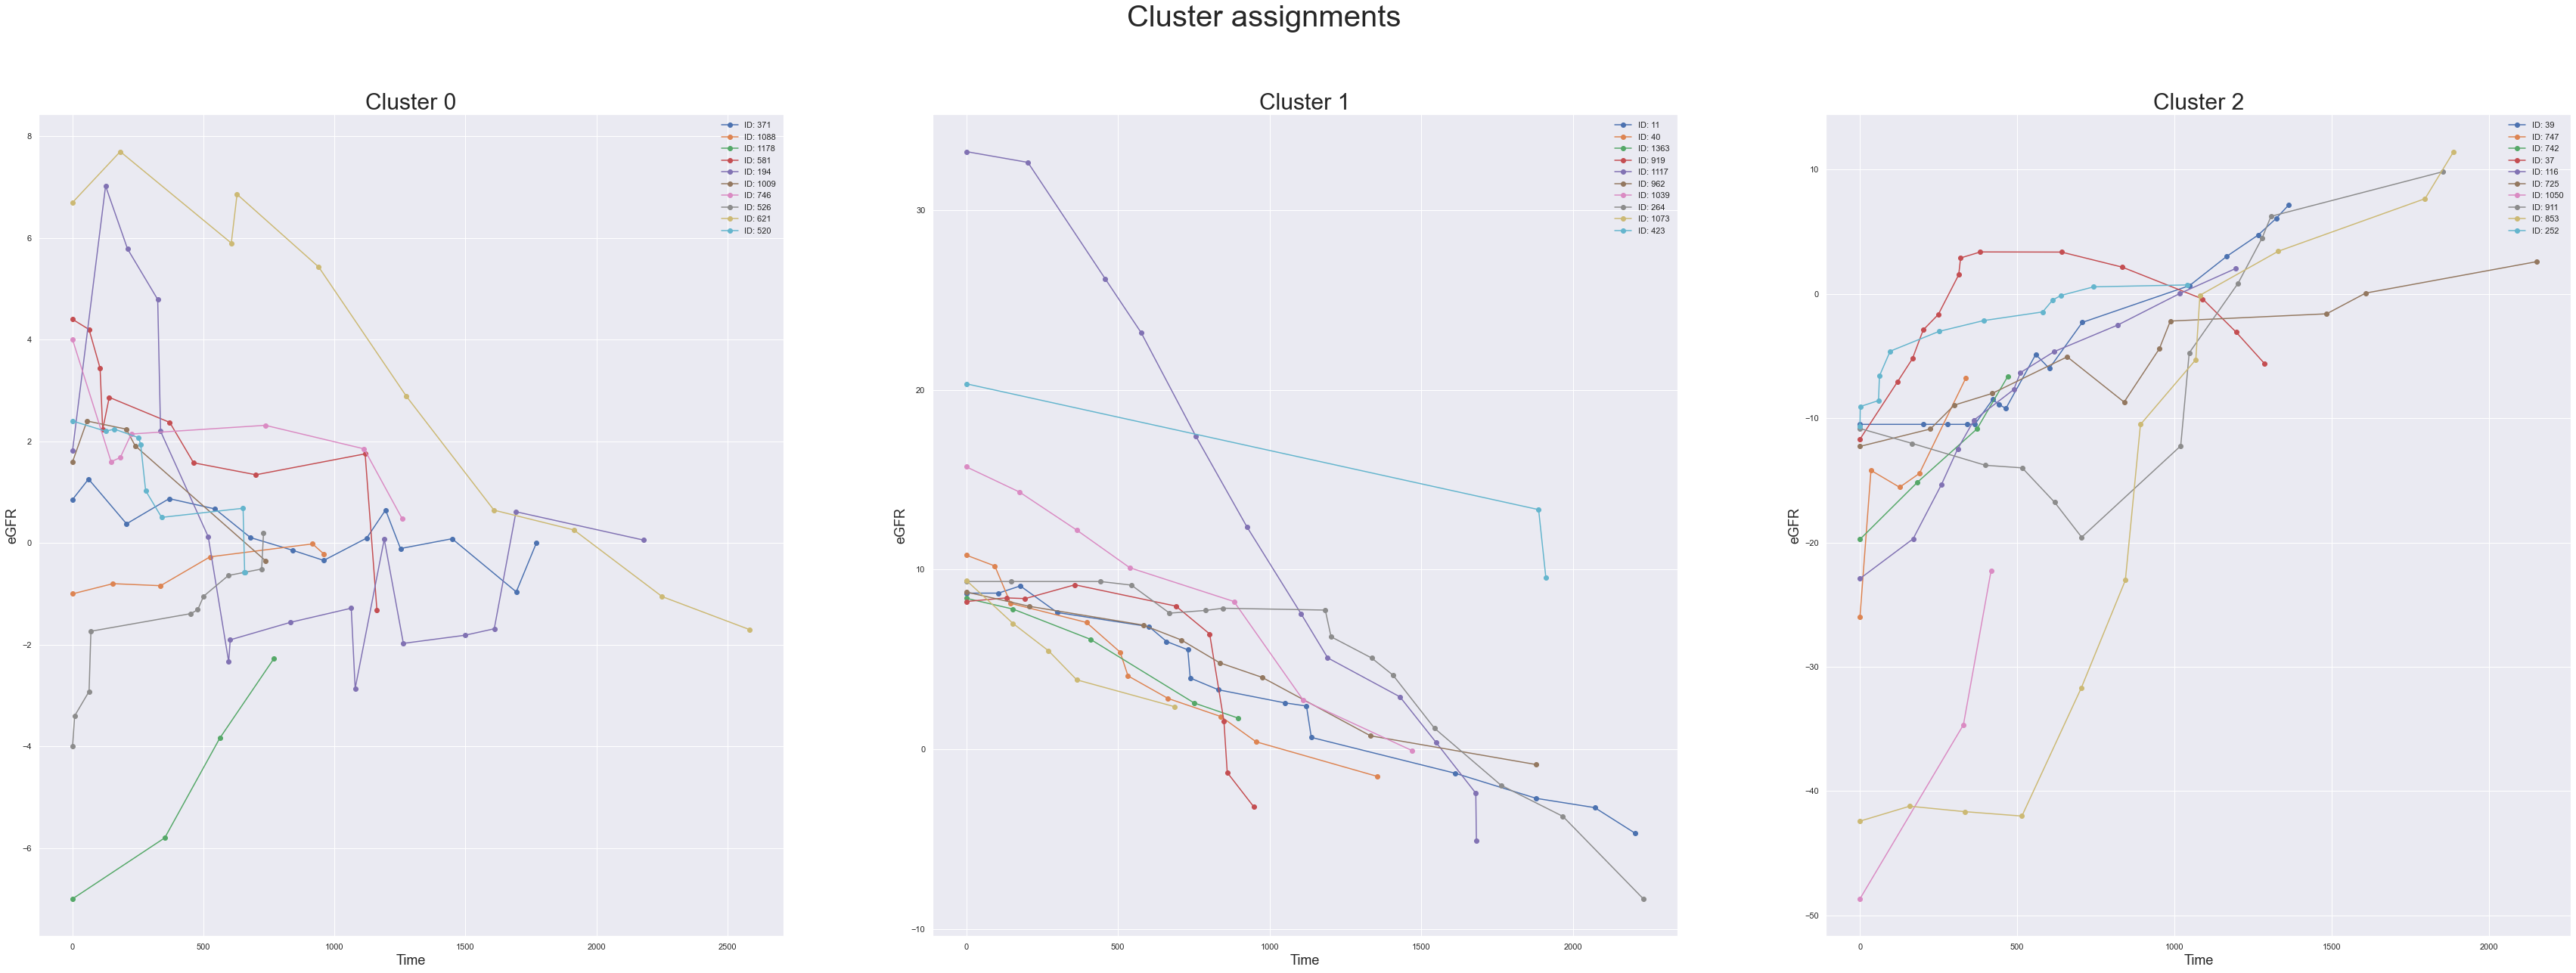

In [18]:
plot_subset_from_pred_clusters(km.labels_, id, time_series, egfr_series, subset_size=10, seed=123, plot_smoothed=True, alpha=0.2)

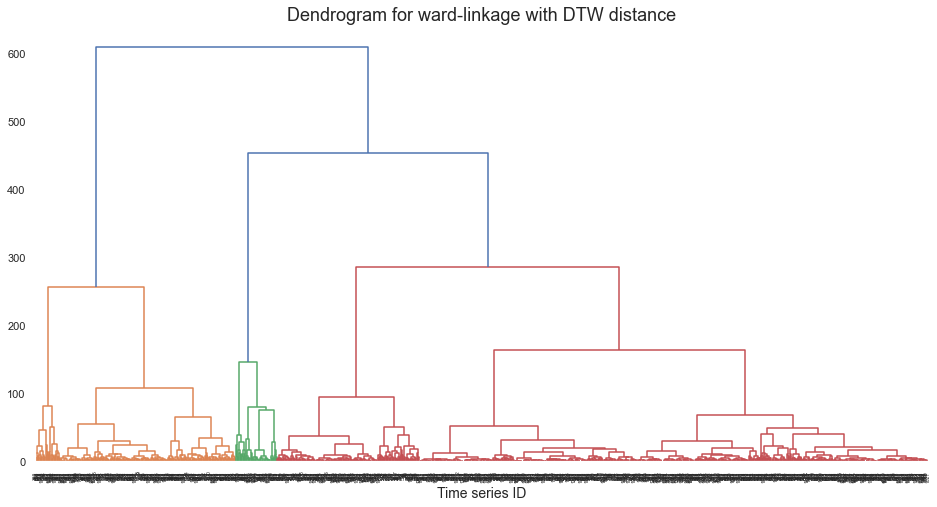

In [18]:
distance_matrix = dtw.distance_matrix_fast([np.array(ts) for ts in egfr_series_smoothed])
condensed_dist_matrix = squareform(distance_matrix)
linkage_matrix = hierarchical_clustering(condensed_dist_matrix, method='ward')
hier_cluster_labels = fcluster(linkage_matrix, t=3, criterion='maxclust')

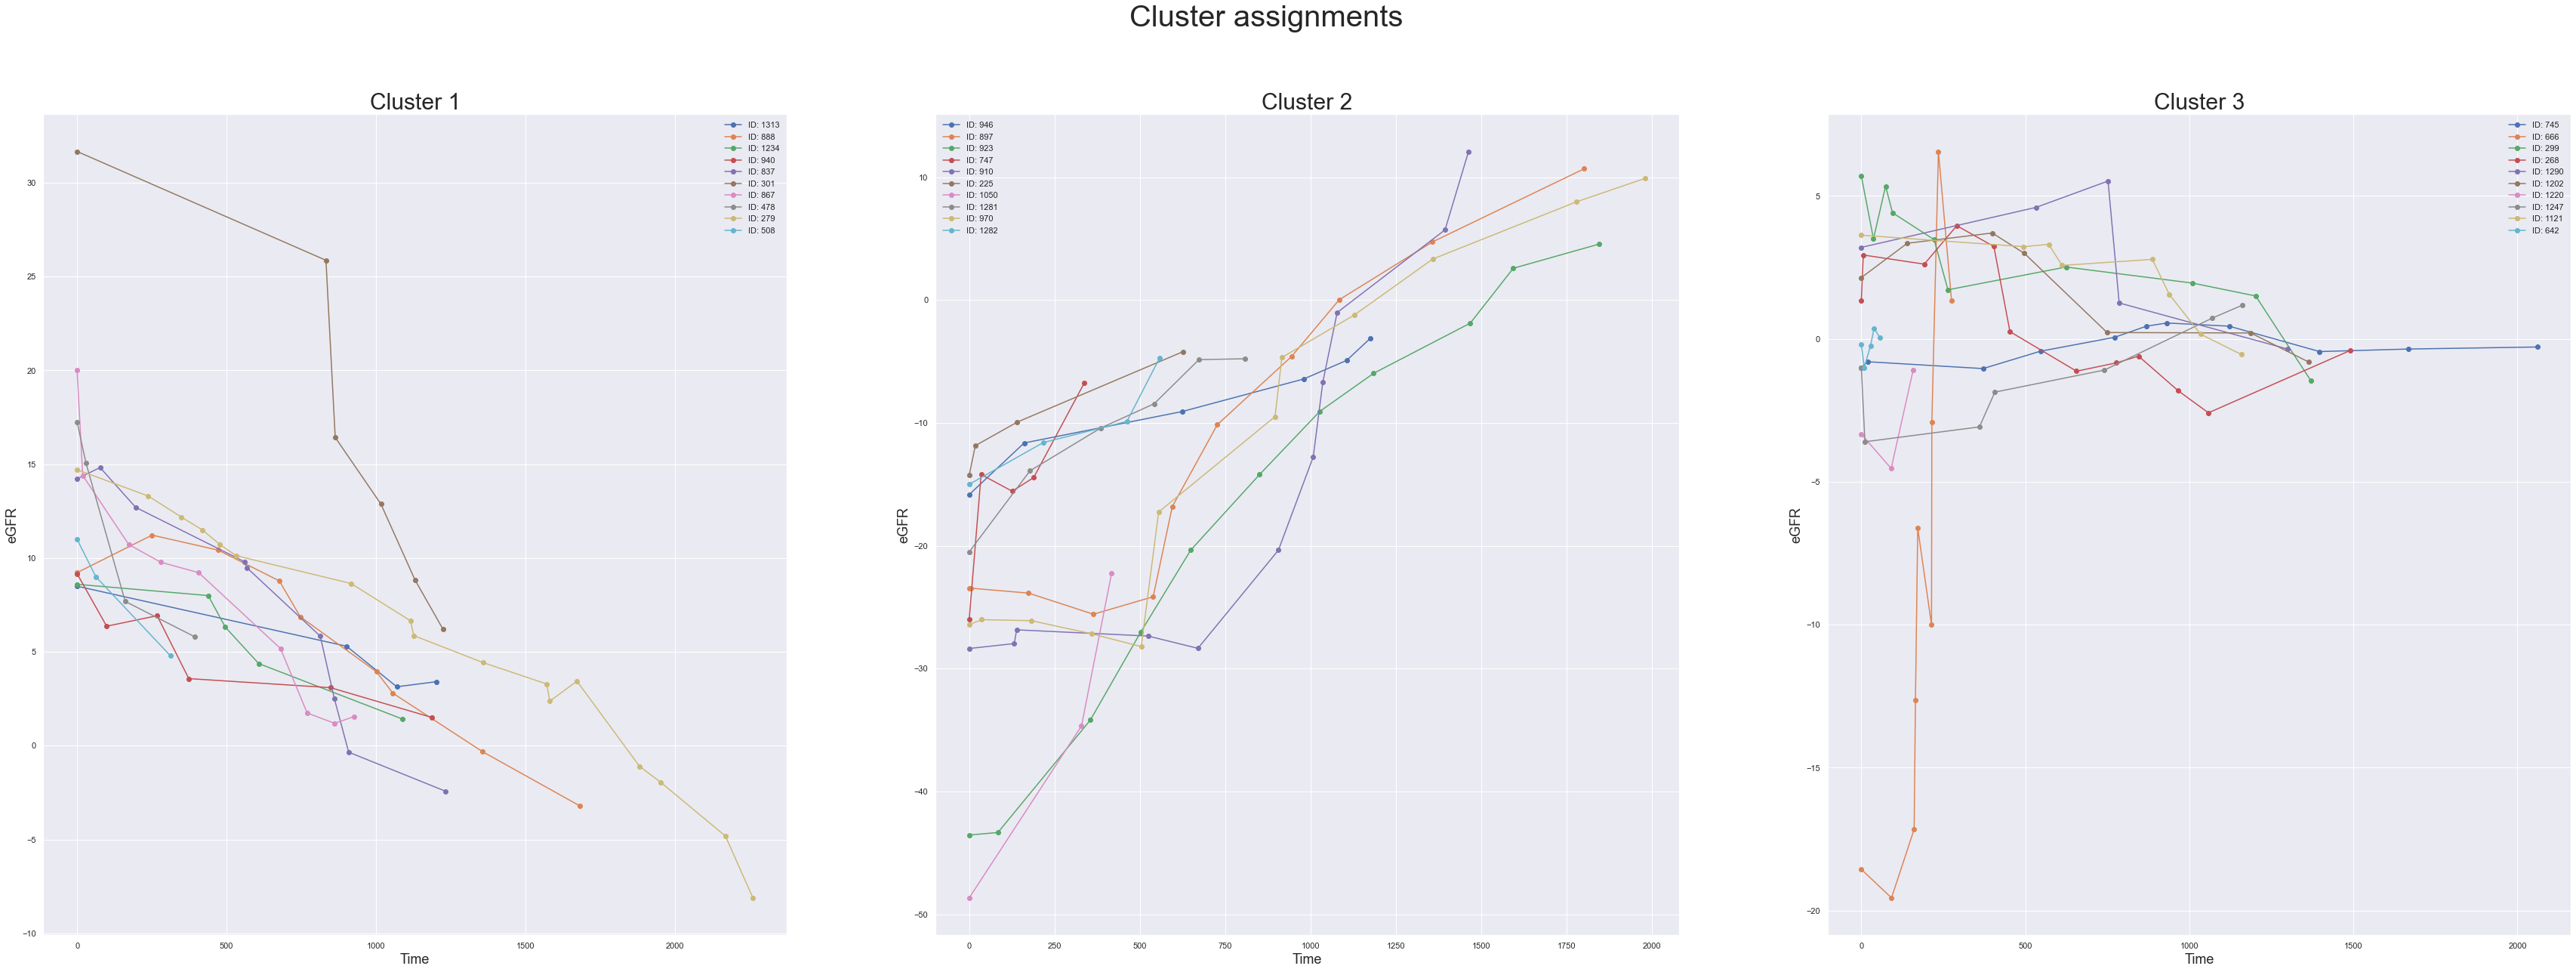

In [19]:
plot_subset_from_pred_clusters(hier_cluster_labels, id, time_series, egfr_series, subset_size=10, seed=13, plot_smoothed=True, alpha=0.2)

Evaluating cluster quality visually is quite hard and tedious, and the plots depend on the randomly selected time-series we choose from each resulting cluster. Thus, even though these plots are quite useful in helping us interpret the resulting clusters, we require a more systematic way of evaluating the quality of the formed clusters in each of the methods we use. In addition, since we don't have access to the ground truth labels, we need to choose a metric which is appropriate for our task. Moreover, since we measure the distance between time series using DTW instead of Euclidean distance, our choice of metrics is reduced to 'Silhouette Coefficient' and 'Calinski-Harabasz Index'. However, after reading the documentation for 'Calinski-Harabasz Index', it became clear that this metric only works for time series of equal length. Hence, the only appropriate metric for our purpose is the Silhouette Coefficient which allows us to pass a precomputed distance matrix using DTW as a custom distance metric. 

### Time series k-means

In [50]:
dtw_distance_matrix = dtw.distance_matrix_fast([np.array(ts) for ts in egfr_series_smoothed])
X_train = to_time_series_dataset(egfr_series_smoothed)

km = TimeSeriesKMeans(n_clusters=3,
                           metric="dtw",
                           n_init=3,
                           verbose=False,
                           random_state=1, 
                           n_jobs=-1)
                           
k_means_labels = km.fit_predict(X_train)
k_means_ss = silhouette_score(X=dtw_distance_matrix, labels=k_means_labels, metric='precomputed')
k_means_sil_vals = silhouette_samples(X=dtw_distance_matrix, labels=k_means_labels, metric='precomputed')
print(f'Silhouette score using k-means: {k_means_ss :.3f}')

Silhouette score using k-means: 0.516


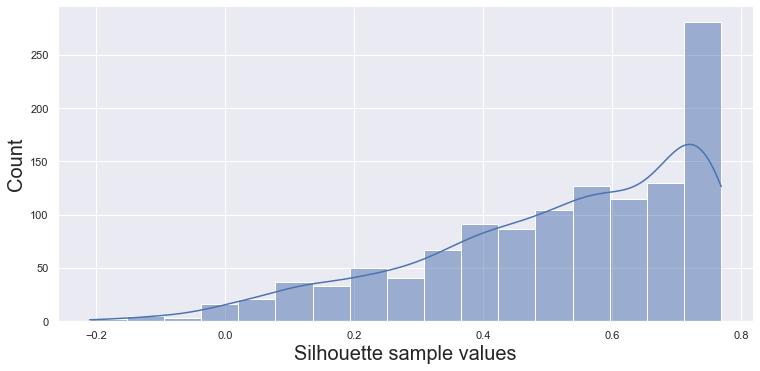

In [55]:
sil_plot = sns.displot(k_means_sil_vals, kde=True)
sil_plot.fig.set_figheight(5)
sil_plot.fig.set_figwidth(12)
sil_plot.set_xlabels('Silhouette sample values', fontsize=20);
sil_plot.set_ylabels('Count', fontsize=20);
sil_plot.set_titles('Distribution of Silhouette values', fontsize=24);

Let's try and plot a random subset of eGFR trajectories of which their Silhouette value is high enough, which is an indication that this trajectory has been assigned to the correct cluster. 

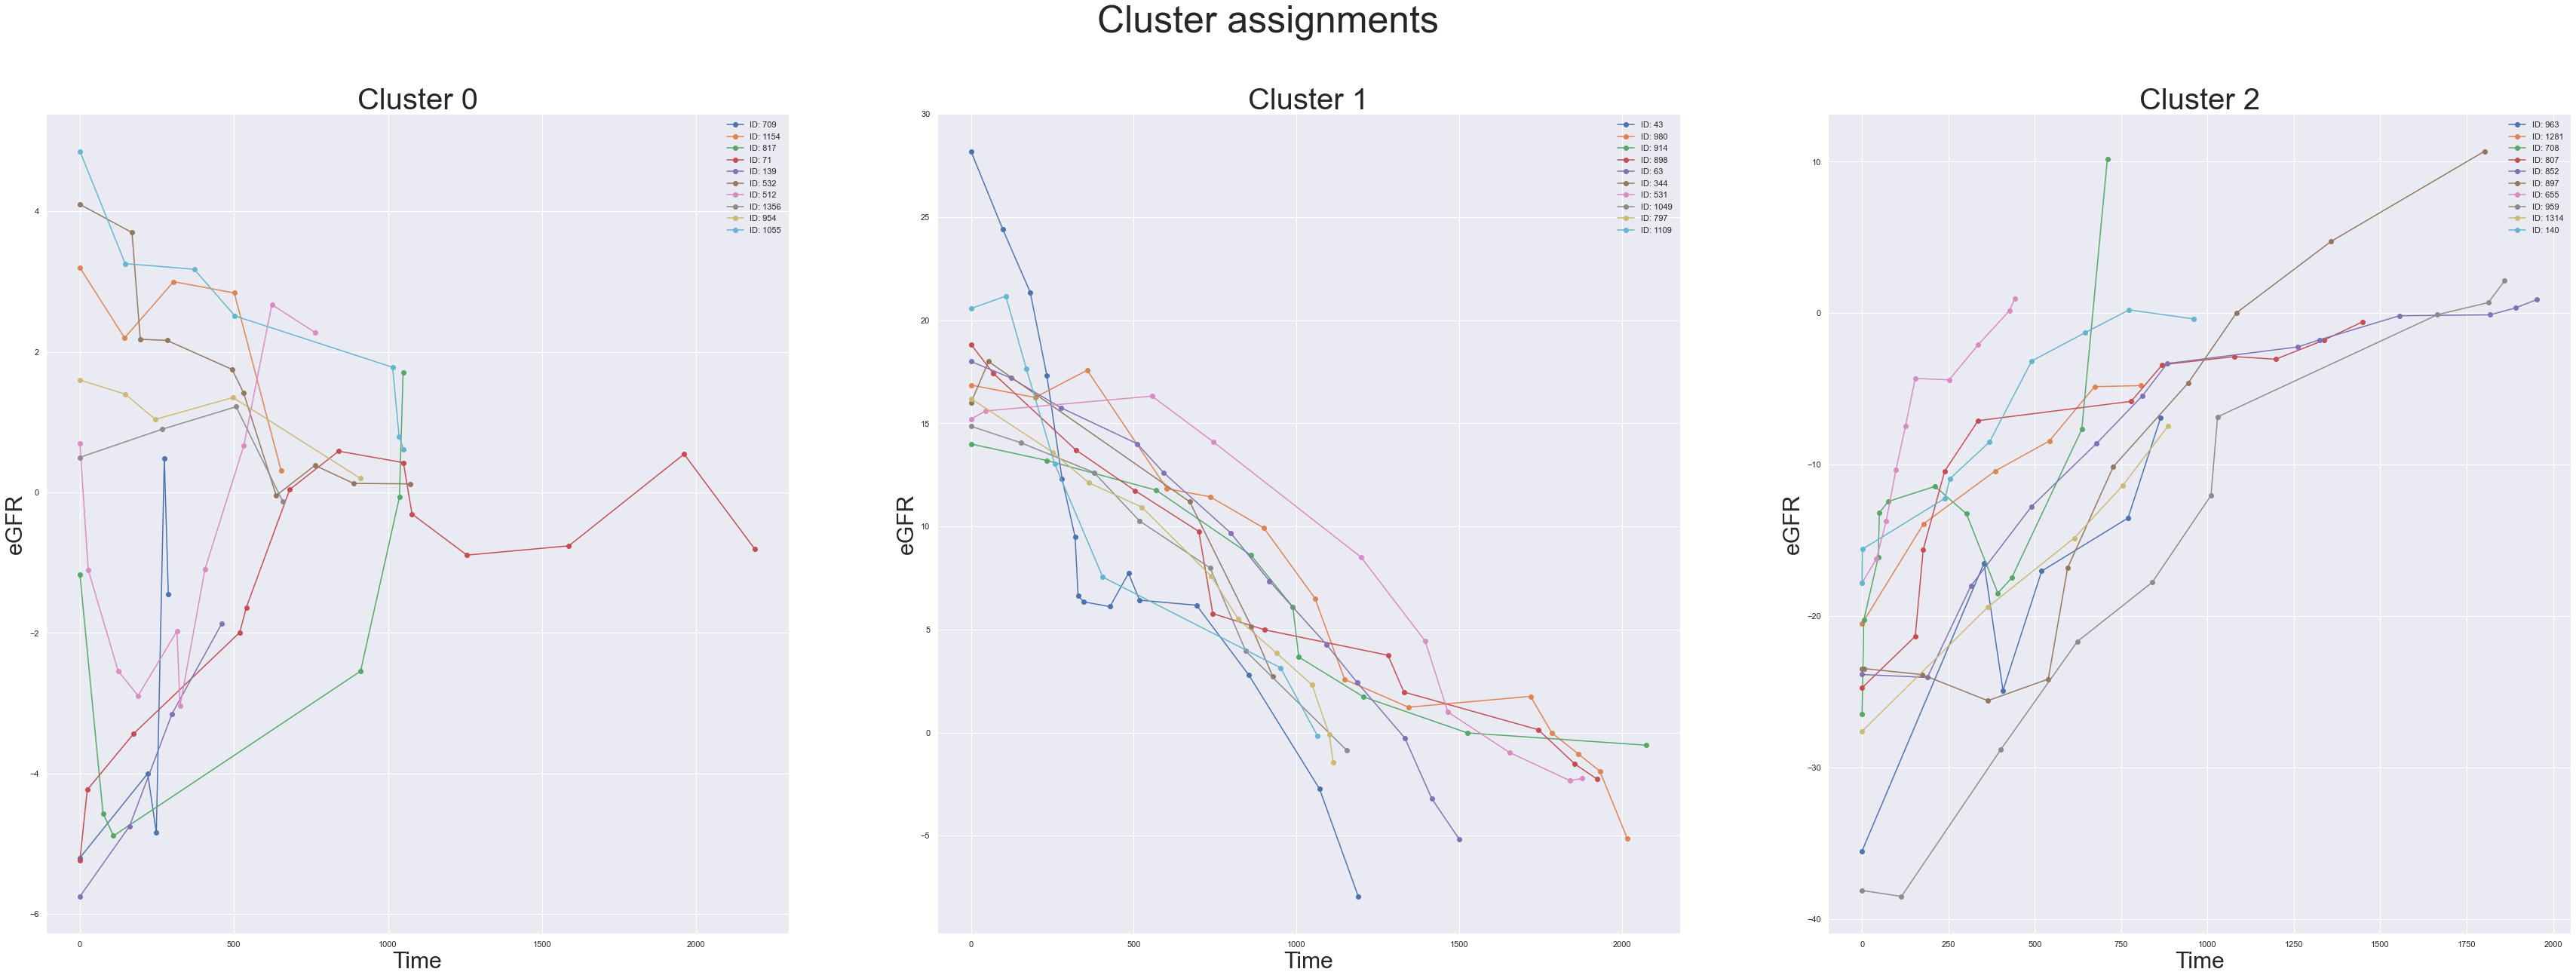

In [53]:
good_ind_k_means = np.where(silhouette_samples(X=dtw_distance_matrix, labels=k_means_labels, metric='precomputed') > 0.50)[0] # indices of 'well' clustered data points

good_k_means_labels = k_means_labels[good_ind_k_means]
good_id_k_means = [id[x] for x in good_ind_k_means]
good_time_series_k_means = [time_series[x] for x in good_ind_k_means]
good_egfr_series_k_means = [egfr_series[x] for x in good_ind_k_means]

# Let's plot the result
plot_subset_from_pred_clusters(good_k_means_labels, good_id_k_means, good_time_series_k_means, good_egfr_series_k_means, subset_size=10, seed=11, plot_smoothed=True, alpha=0.2)

Seems like the clusters produced represent three types of patients: 
1) Patients who get worse (decreasing trend in their eGFR trajectories)
2) Patients who improve (increasing trend in their eGFR trajectories)
3) Patients with no clear progression status (no clear trend in their eGFR trajectories)

### Time series k-medoids

In [32]:
k_med_model = clustering.KMedoids(dists_fun=dtw.distance_matrix_fast, k=3, dists_options={})
k_meds_cluster_idx = k_med_model.fit([np.array(ts) for ts in egfr_series_smoothed])

# Assign cluster labels: clusters are 0, 1, 2
k_meds_labels = np.zeros_like(k_means_labels)
second_key , third_key = list(k_meds_cluster_idx.keys())[1] , list(k_meds_cluster_idx.keys())[2]
second_cluster_ind = np.concatenate([ np.array([second_key]) , np.array(list(k_meds_cluster_idx[second_key])) ])
third_cluster_ind = np.concatenate([ np.array([third_key]) , np.array(list(k_meds_cluster_idx[third_key])) ])
k_meds_labels[second_cluster_ind] = 1
k_meds_labels[third_cluster_ind] = 2

# Calculate silhouette scores
k_meds_ss = silhouette_score(X=dtw_distance_matrix, labels=k_meds_labels, metric='precomputed')
k_meds_sil_vals = silhouette_samples(X=dtw_distance_matrix, labels=k_meds_labels, metric='precomputed')
print(f'Silhouette score using k-medoids: {k_meds_ss :.3f}')

Silhouette score using k-medoids: 0.388


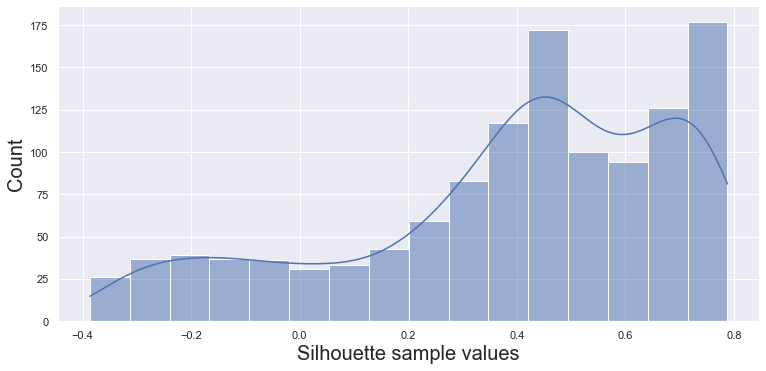

In [33]:
sil_plot = sns.displot(k_meds_sil_vals, kde=True)
sil_plot.fig.set_figheight(5)
sil_plot.fig.set_figwidth(12)
sil_plot.set_xlabels('Silhouette sample values', fontsize=20);
sil_plot.set_ylabels('Count', fontsize=20);
sil_plot.set_titles('Distribution of Silhouette values', fontsize=24);

## Hierarchical Agglomerative clustering

Only the 'Ward' linkage method seems to be producing meaningful results

In [40]:
clust_method = 'ward' # choose from [complete, single, average, ward]
hier_distance_matrix = dtw.distance_matrix_fast([np.array(ts) for ts in egfr_series_smoothed])
condensed_dist_matrix = squareform(hier_distance_matrix)
linkage_matrix = hierarchical_clustering(condensed_dist_matrix, method=clust_method, plot_dendrogram=False)
hier_labels = fcluster(linkage_matrix, t=3, criterion='maxclust')

# Calculate silhouette scores
hier_ss = silhouette_score(X=hier_distance_matrix, labels=hier_labels, metric='precomputed')
hier_sil_vals = silhouette_samples(X=hier_distance_matrix, labels=hier_labels, metric='precomputed')
print(f'Silhouette score using Hierarchical clustering: {hier_ss :.3f}')

Silhouette score using Hierarchical clustering: 0.507


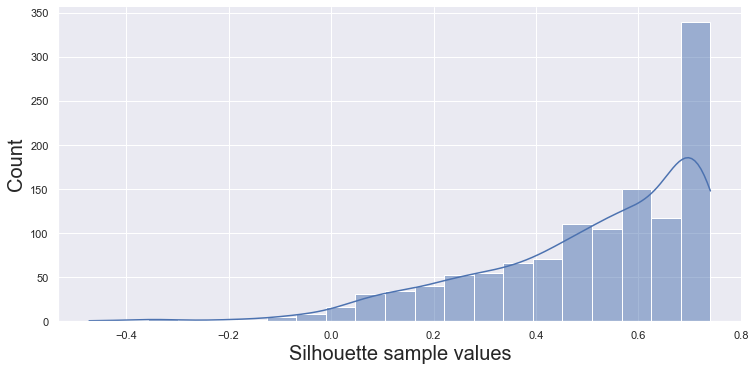

In [35]:
sil_plot = sns.displot(hier_sil_vals, kde=True)
sil_plot.fig.set_figheight(5)
sil_plot.fig.set_figwidth(12)
sil_plot.set_xlabels('Silhouette sample values', fontsize=20);
sil_plot.set_ylabels('Count', fontsize=20);
sil_plot.set_titles('Distribution of Silhouette values', fontsize=24);

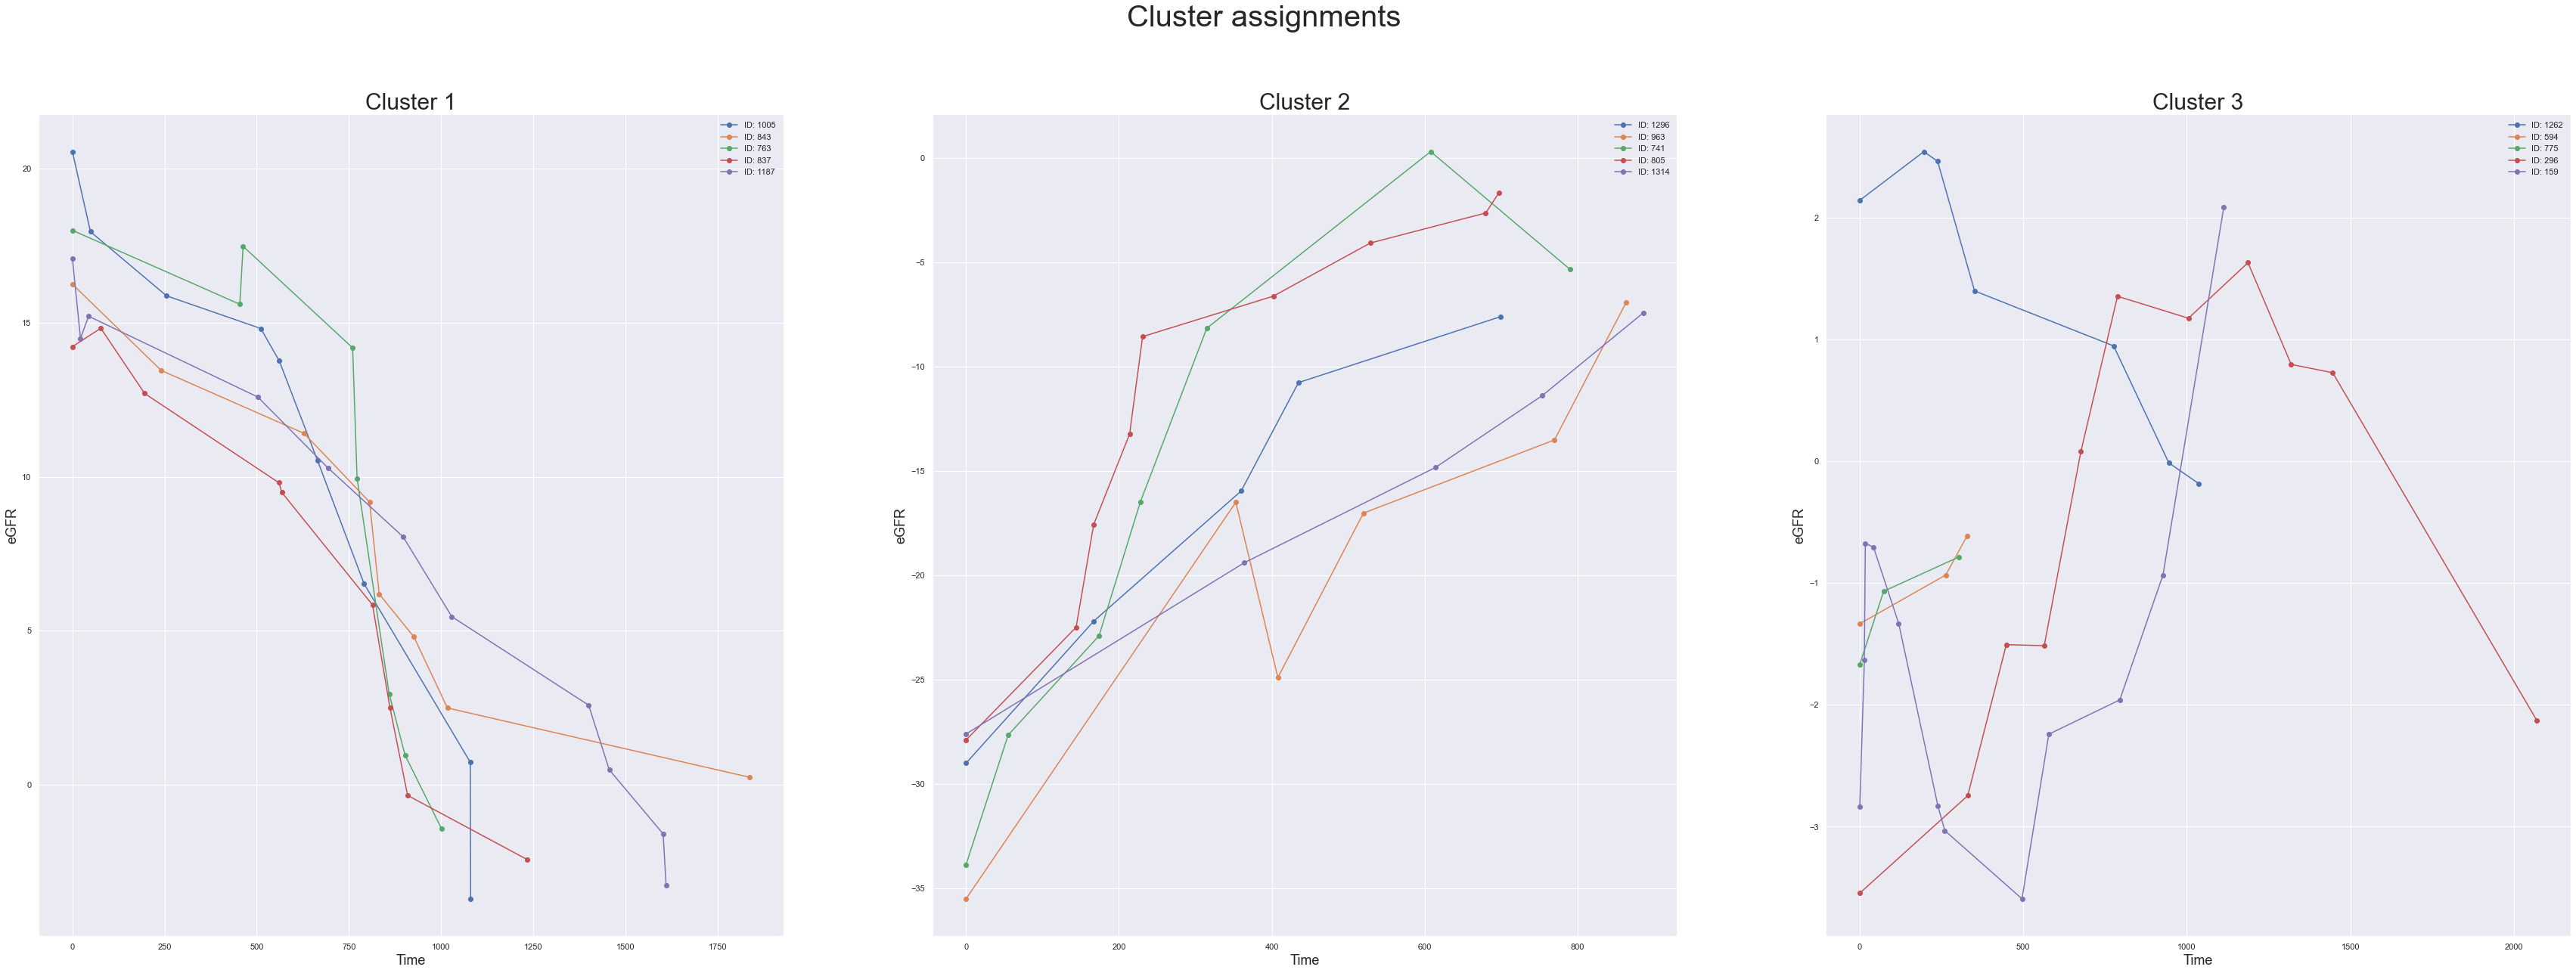

In [36]:
good_ind_hier = np.where(silhouette_samples(X=hier_distance_matrix, labels=hier_labels, metric='precomputed') > 0.60)[0] # index of 'well' clustered data points

good_hier_labels = hier_labels[good_ind_hier]
good_id_hier = [id[x] for x in good_ind_hier]
good_time_series_hier = [time_series[x] for x in good_ind_hier]
good_egfr_series_hier = [egfr_series[x] for x in good_ind_hier]

# Let's plot the result
plot_subset_from_pred_clusters(good_hier_labels, good_id_hier, good_time_series_hier, good_egfr_series_hier, subset_size=5, seed=11, plot_smoothed=True, alpha=0.2)

### Judging by the Silhouette scores of the three methods and the resulting clusters formed it seems that k-medoids has the worst performance, followed by agglomerative hierarchical clustering with a ward linkage, and then closely followed by k-means. 

## Visually inspecting the resulting k-means clusters, since k-means seems to be producing the best results

Increasing trend cluster

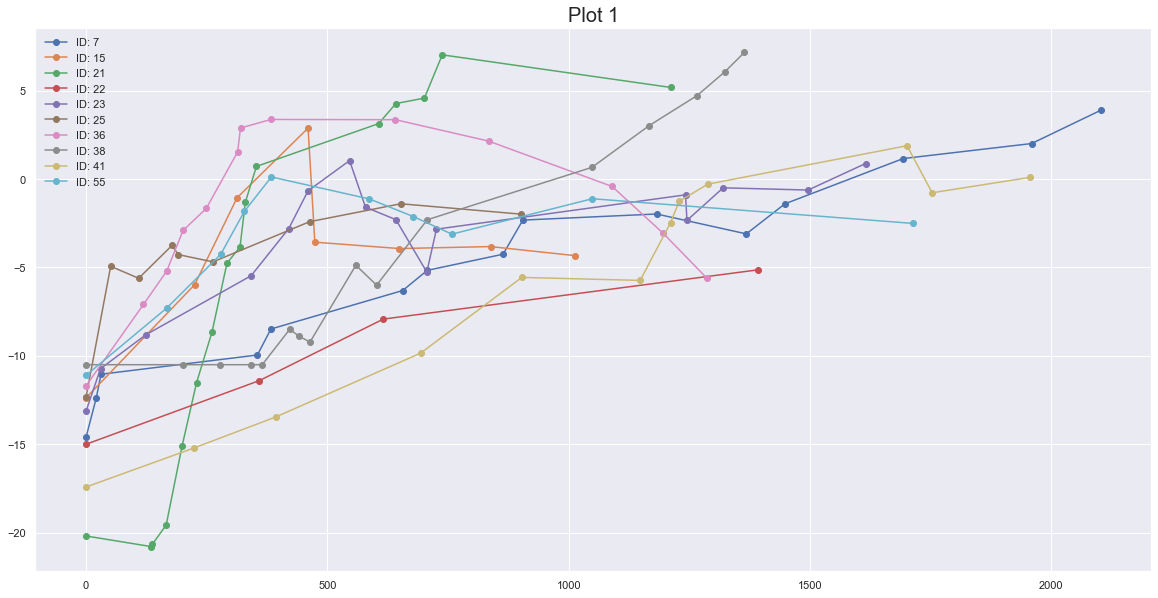

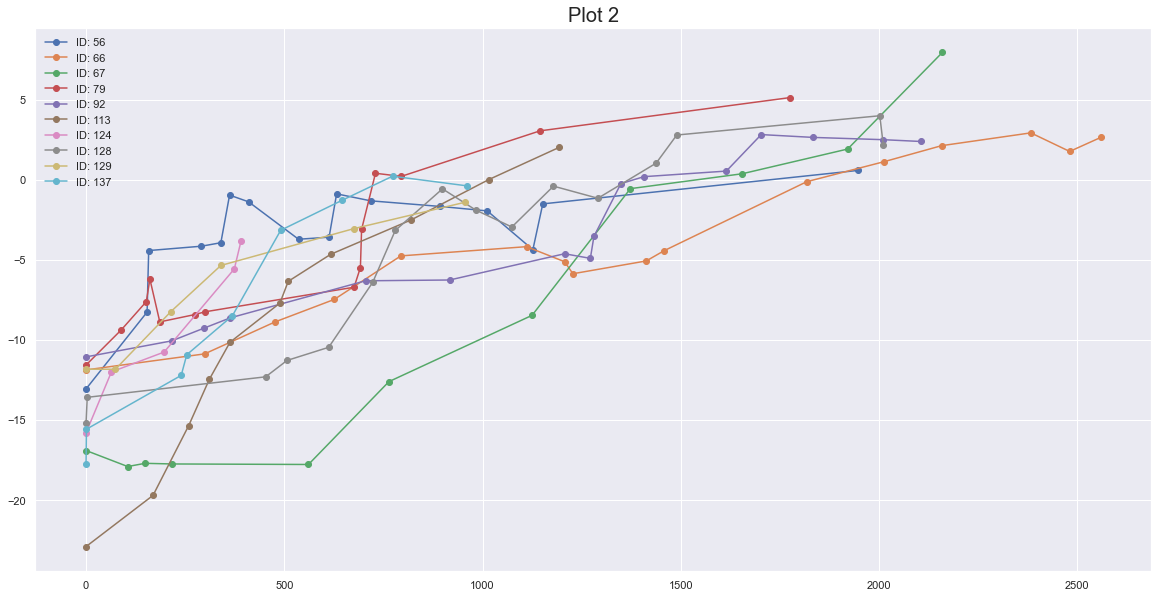

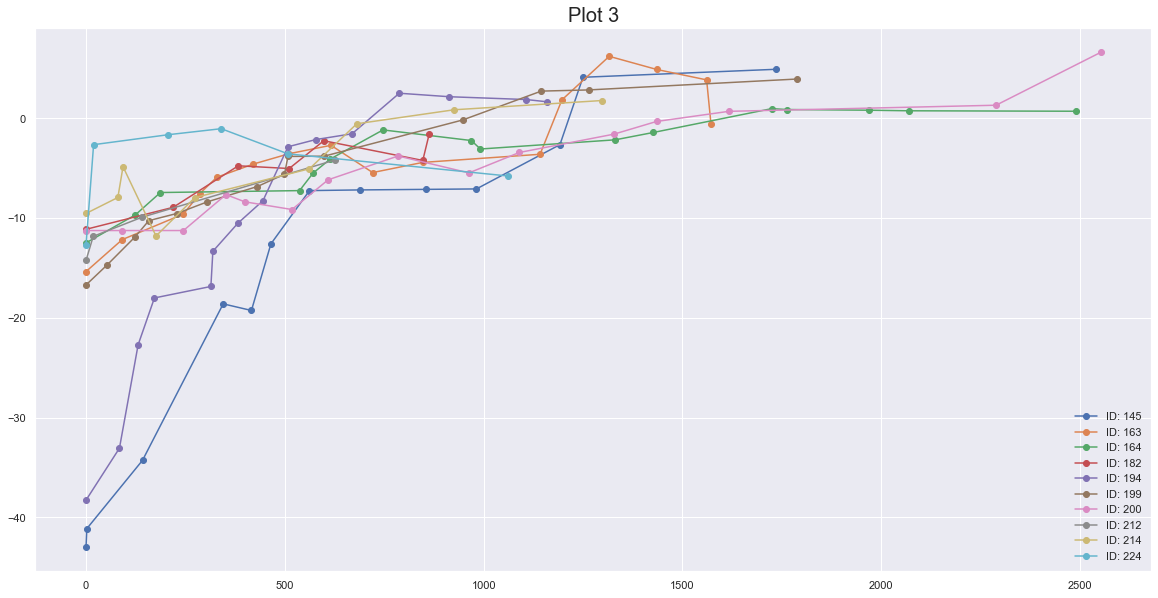

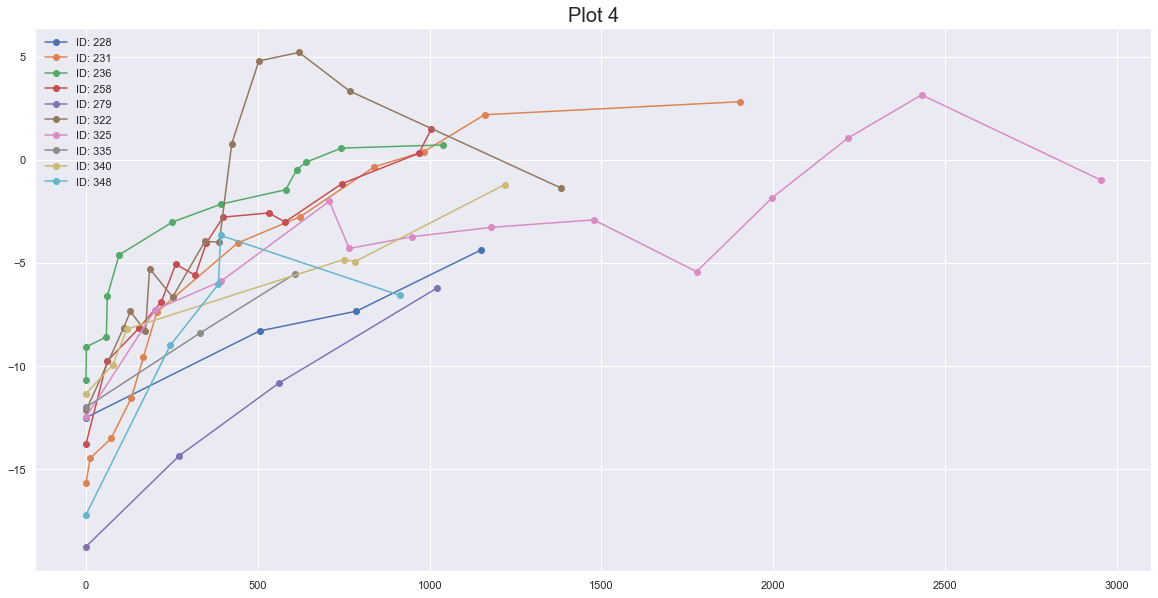

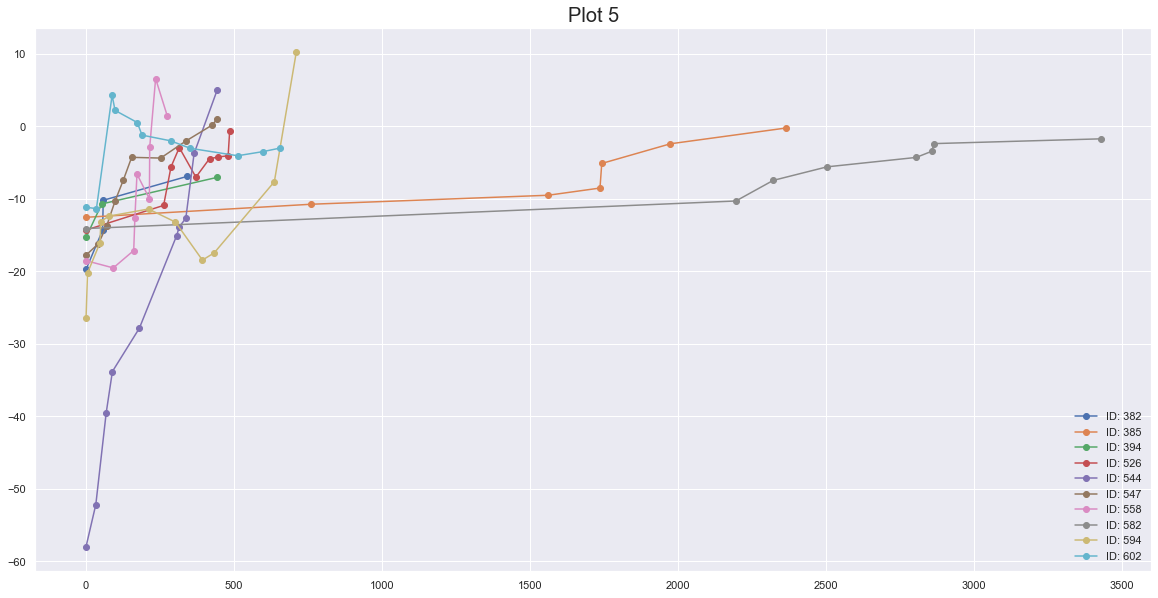

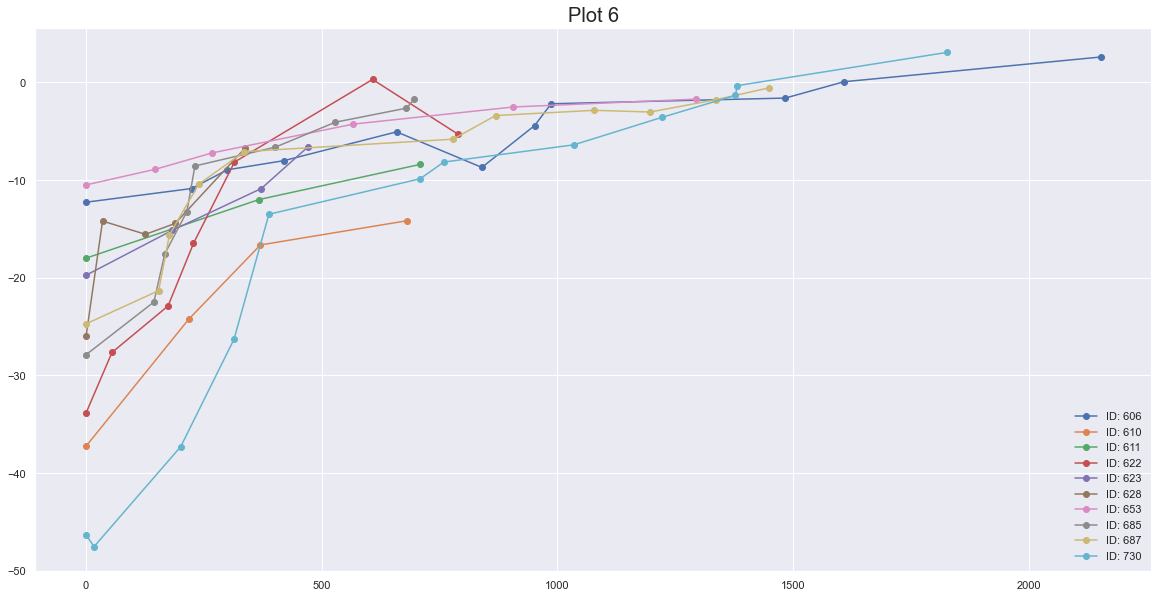

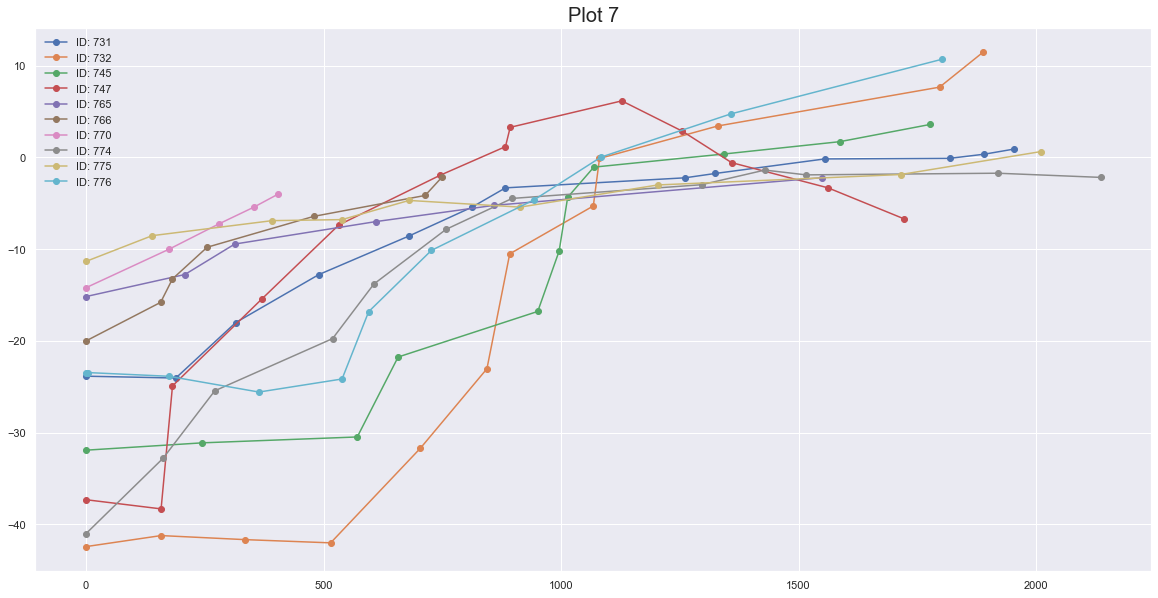

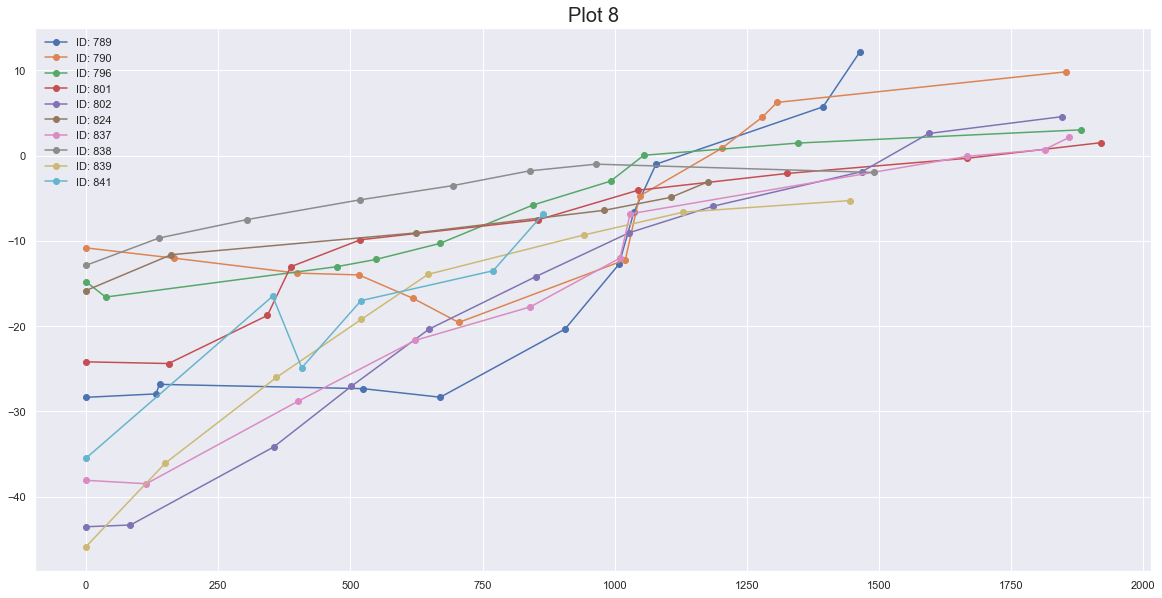

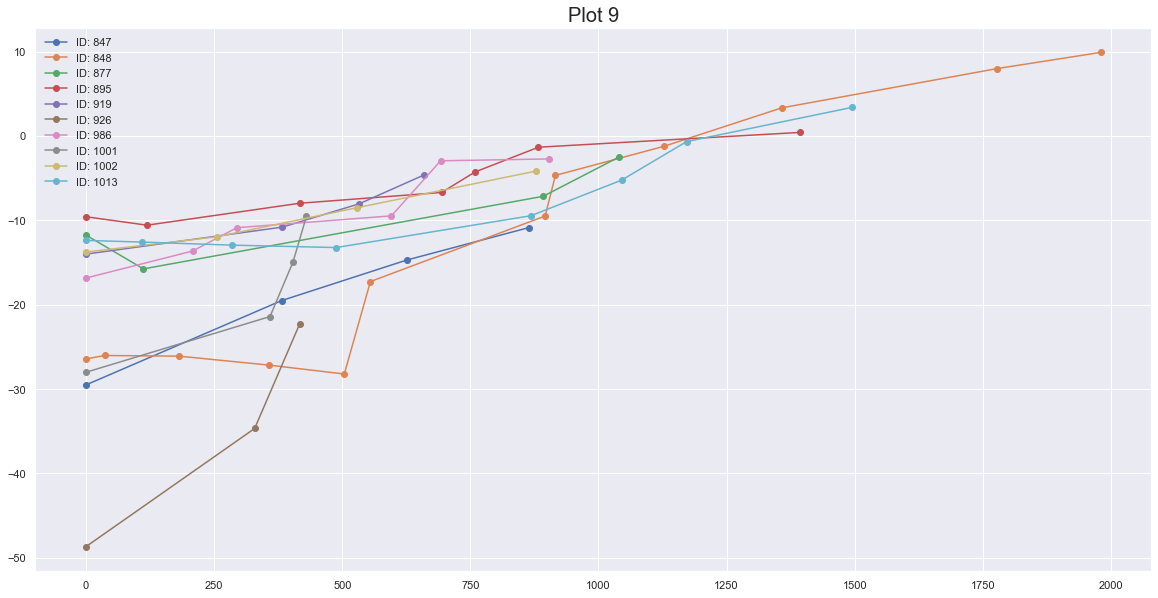

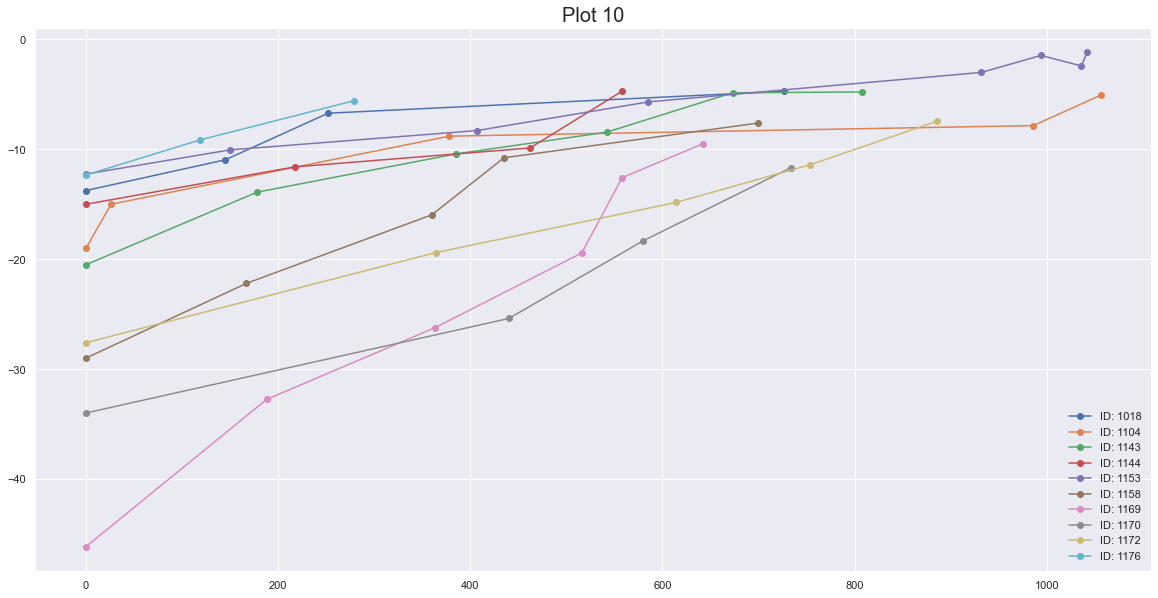

In [60]:
k_means_increasing_ind = np.where(k_means_labels == 2)[0]

for i in range(10, 110, 10):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ind = k_means_increasing_ind[i-10 : i]
    for j in range(10):
        x , y, idd = time_series[ind[j]] , egfr_series_smoothed[ind[j]], ind[j]
        ax.plot(x, y, '-o', label=f'ID: {idd}')
        ax.legend(frameon = False);
        plt.title(f'Plot {int(i/10)}', fontsize=20)

Decreasing trend cluster

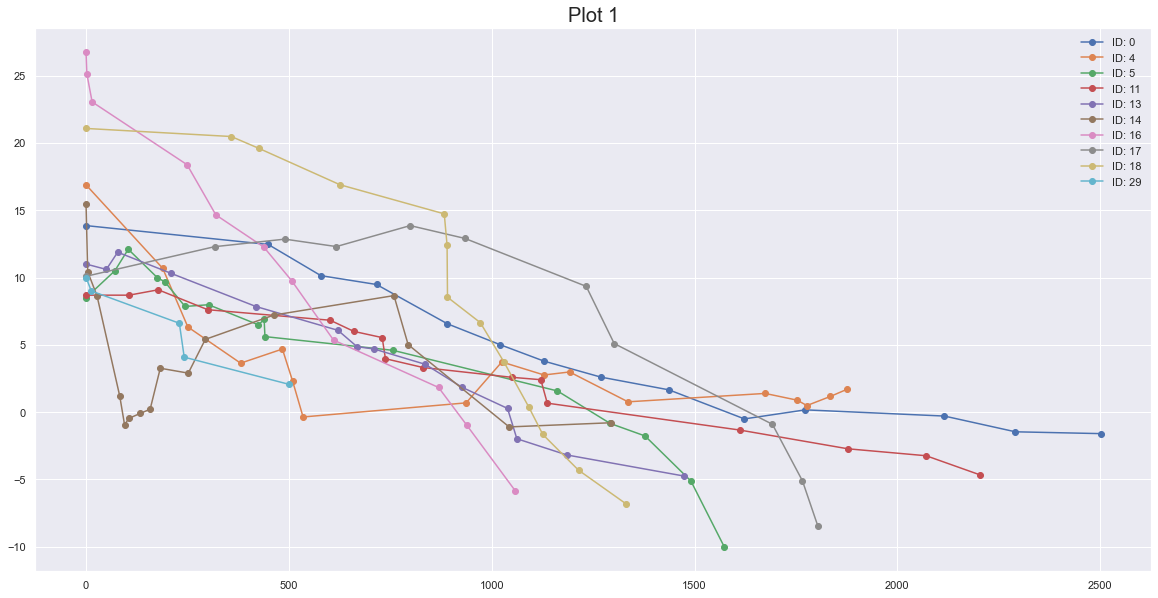

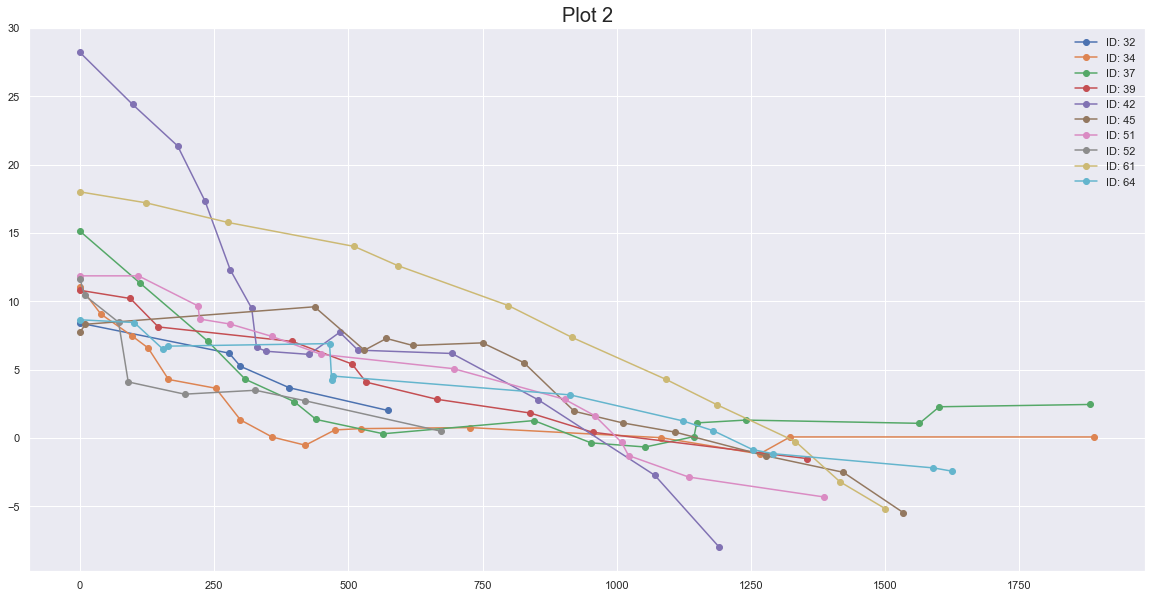

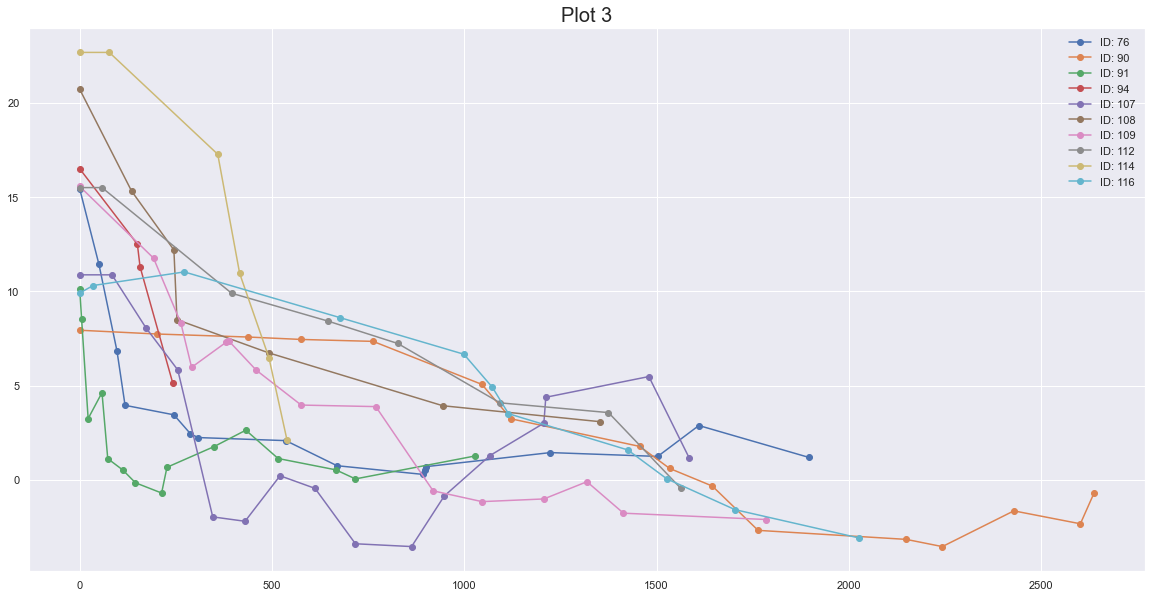

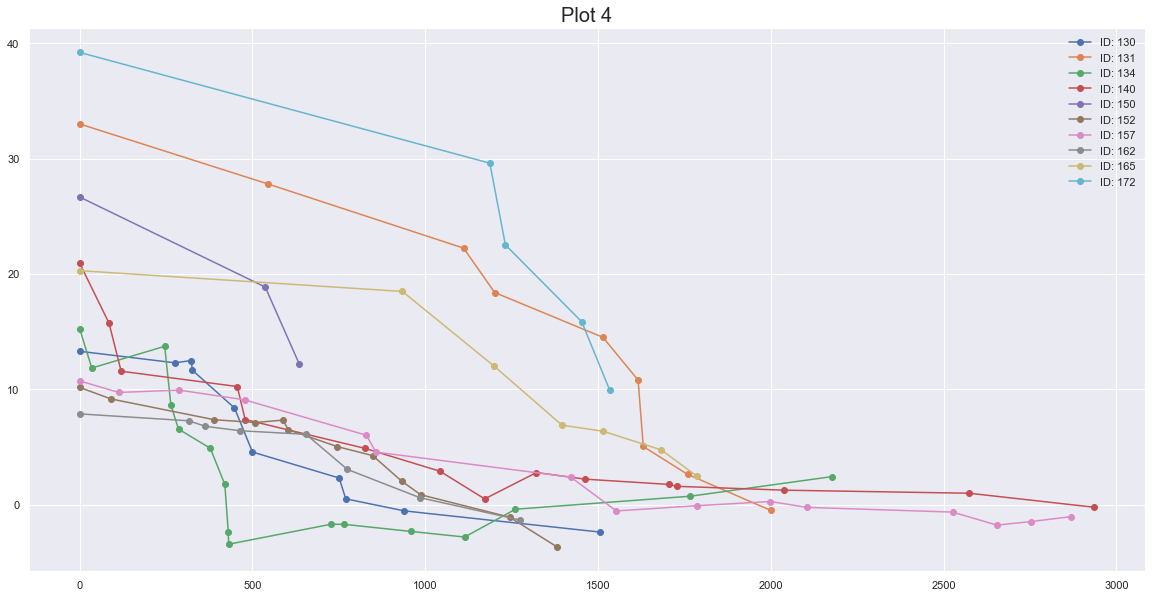

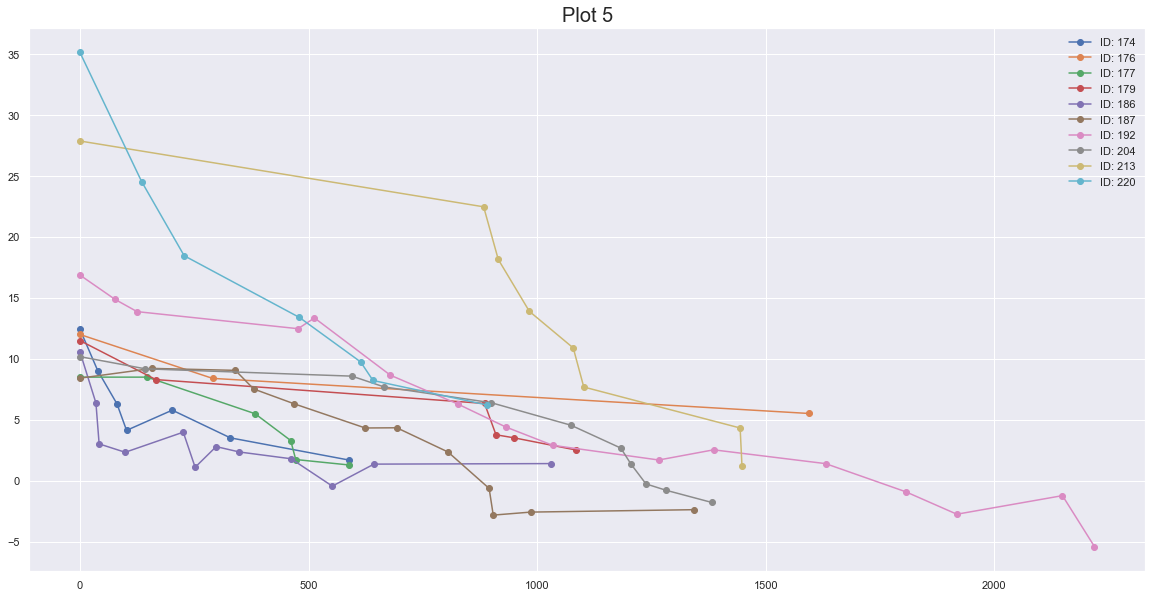

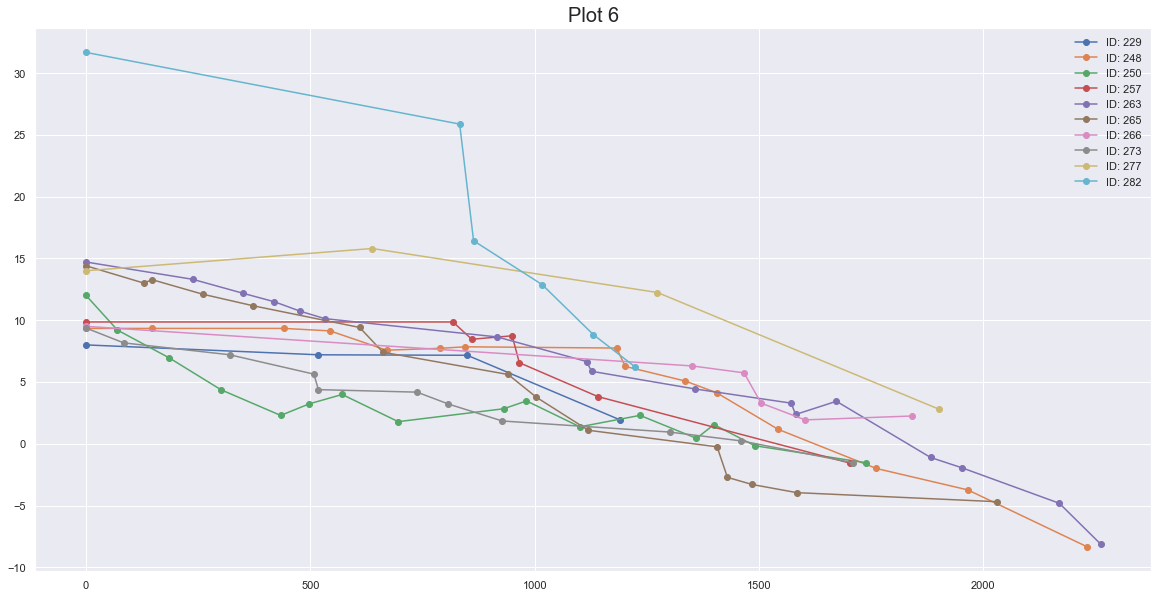

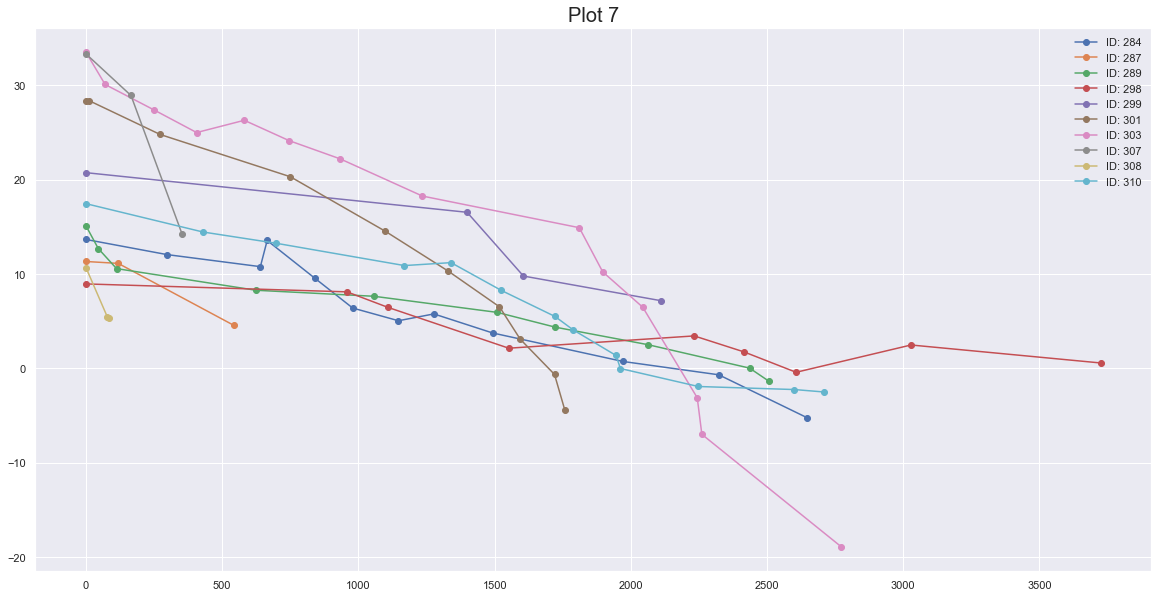

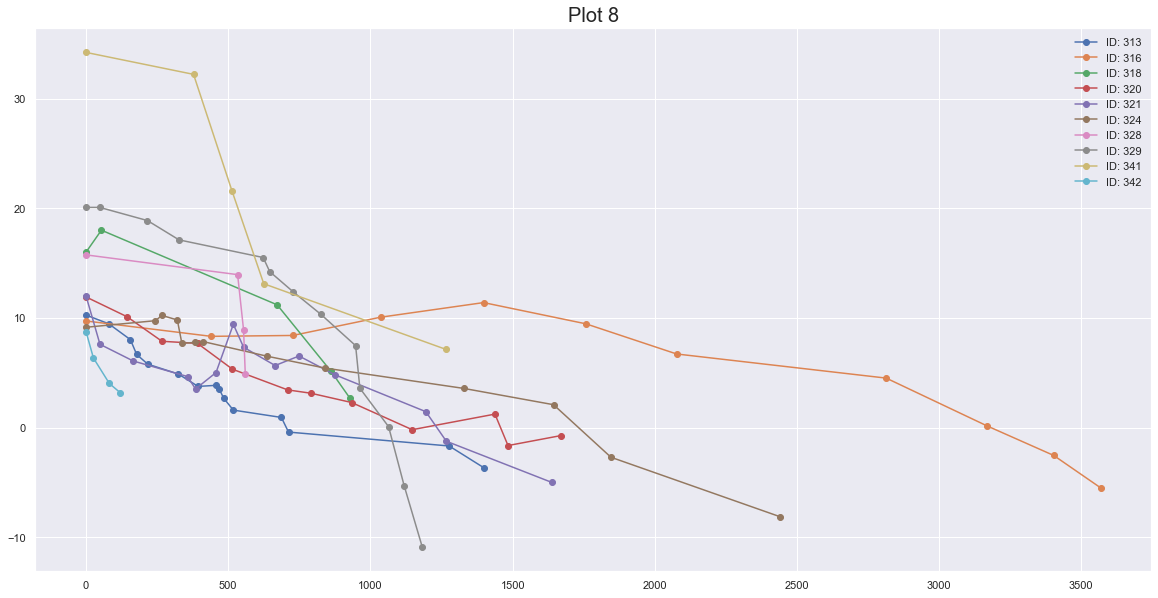

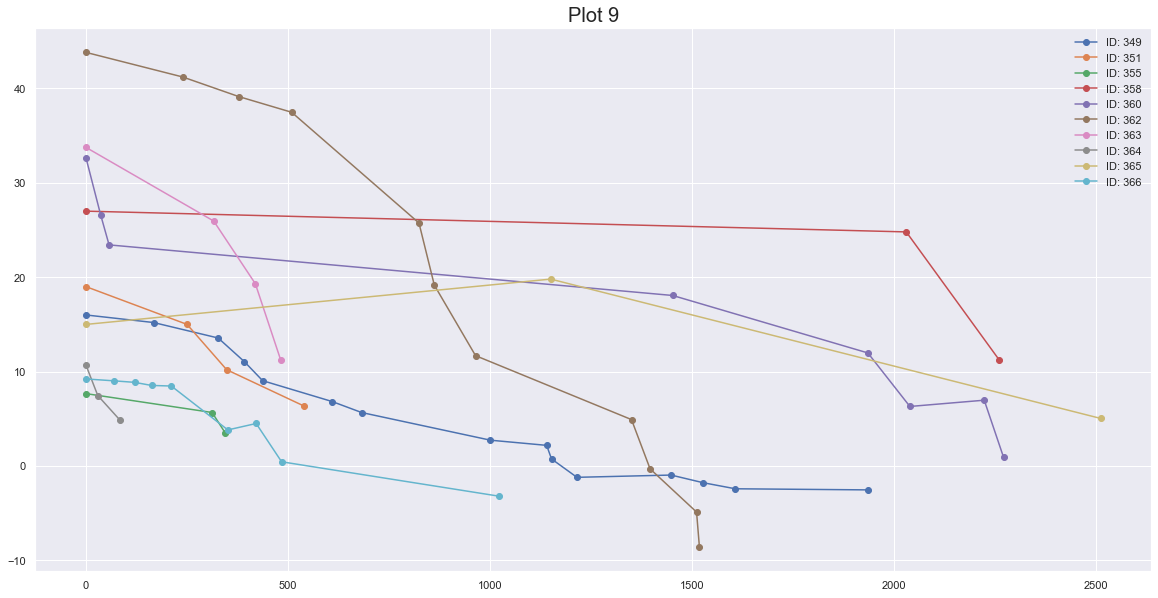

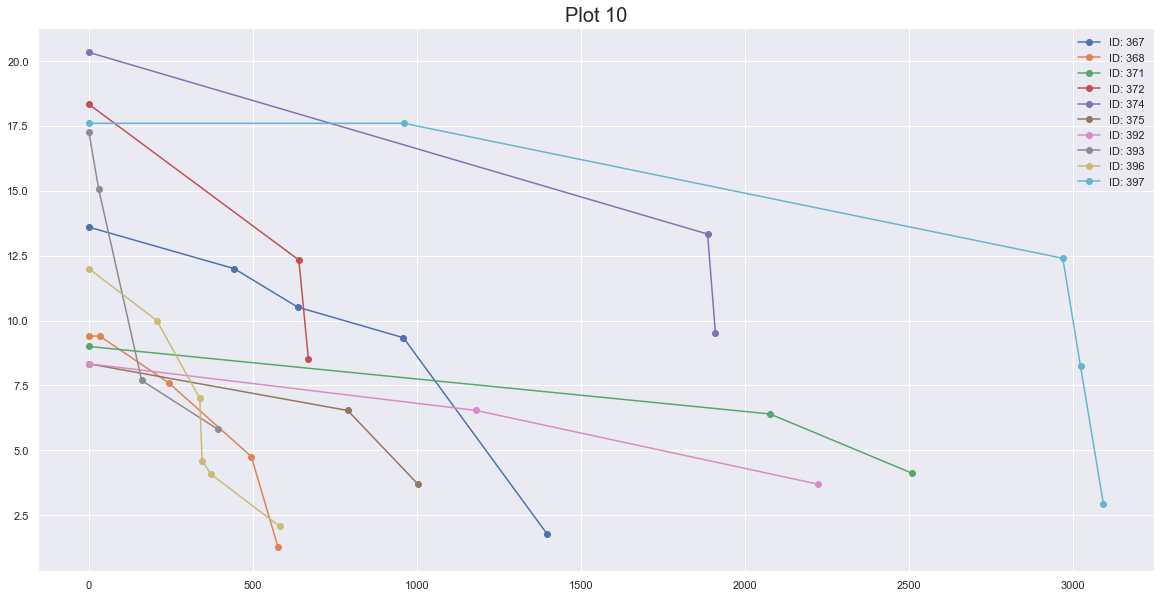

In [62]:
k_means_decreasing_ind = np.where(k_means_labels == 1)[0]

for i in range(10, 110, 10):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ind = k_means_decreasing_ind[i-10 : i]
    for j in range(10):
        x , y, idd = time_series[ind[j]] , egfr_series_smoothed[ind[j]], ind[j]
        ax.plot(x, y, '-o', label=f'ID: {idd}')
        ax.legend(frameon = False);
        plt.title(f'Plot {int(i/10)}', fontsize=20)

Other trend cluster

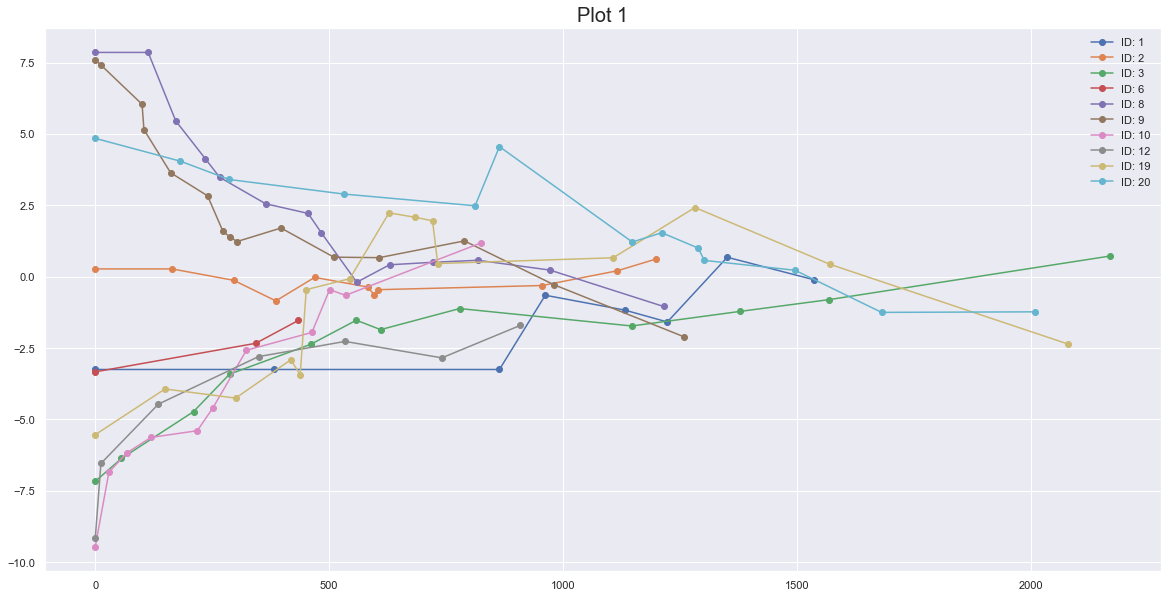

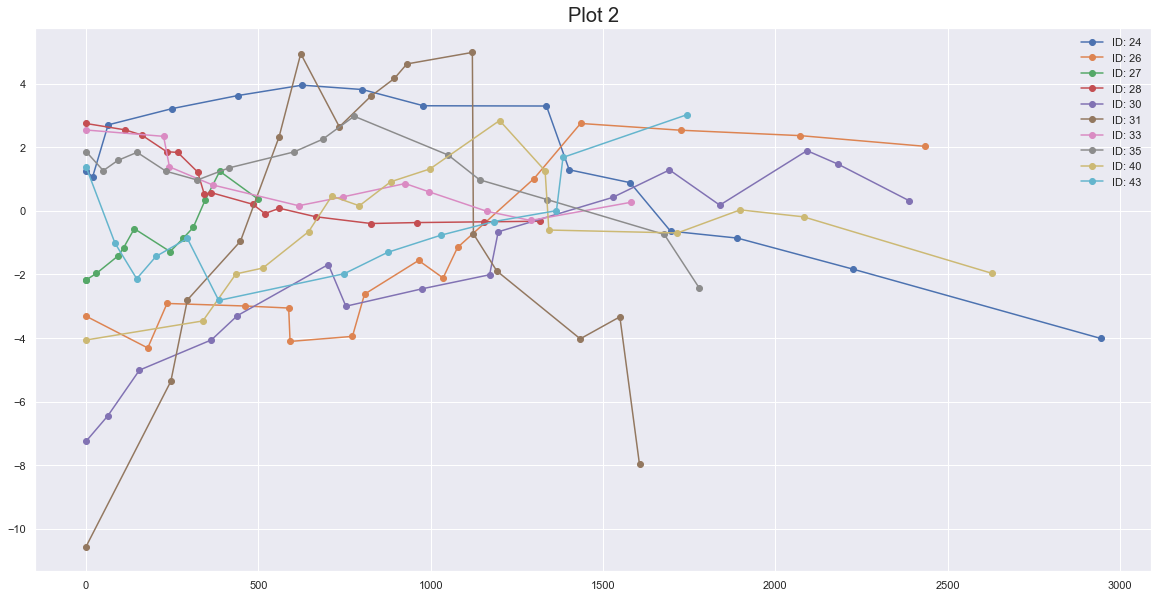

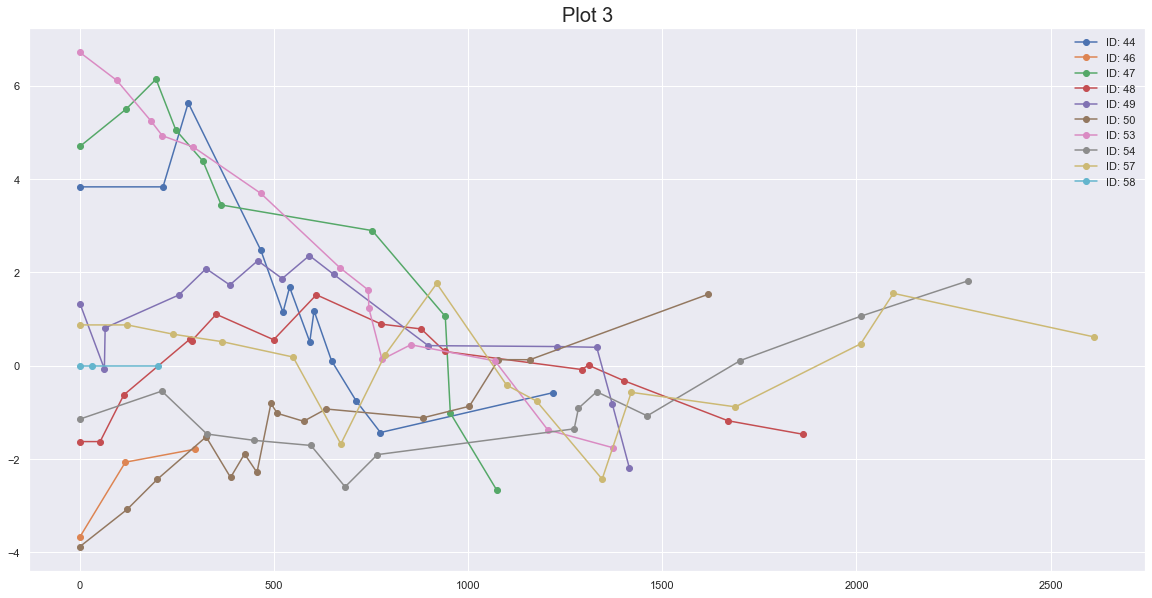

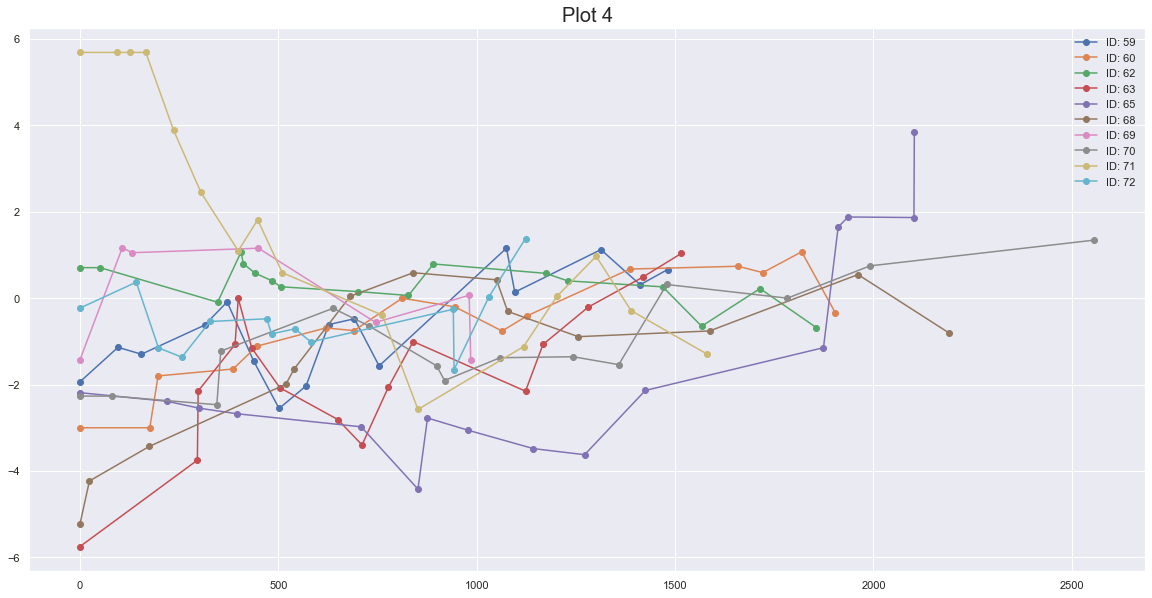

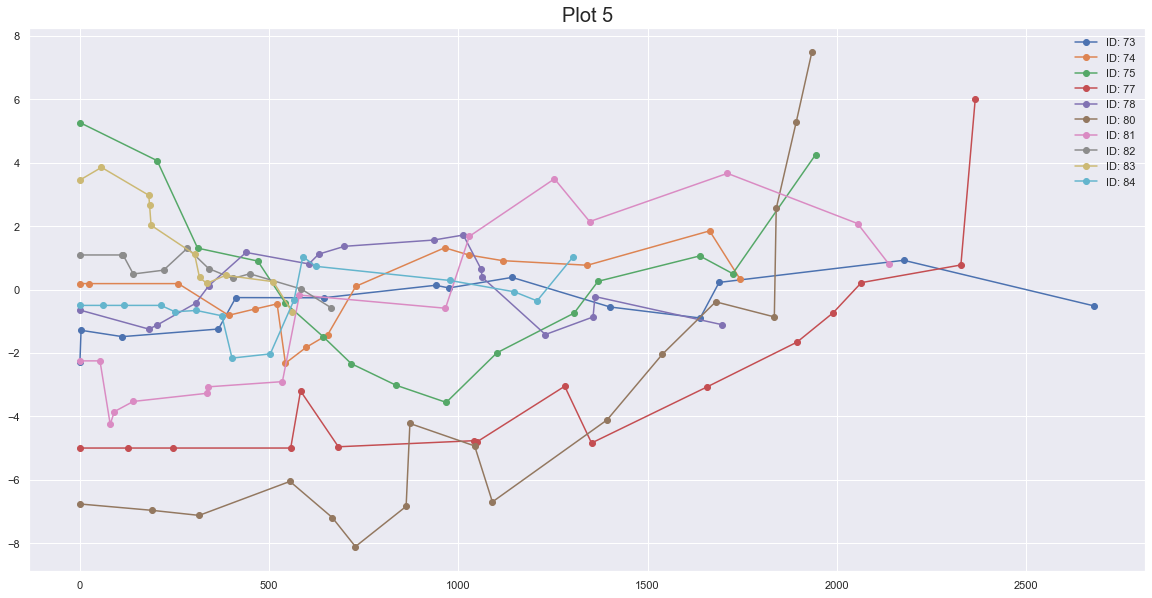

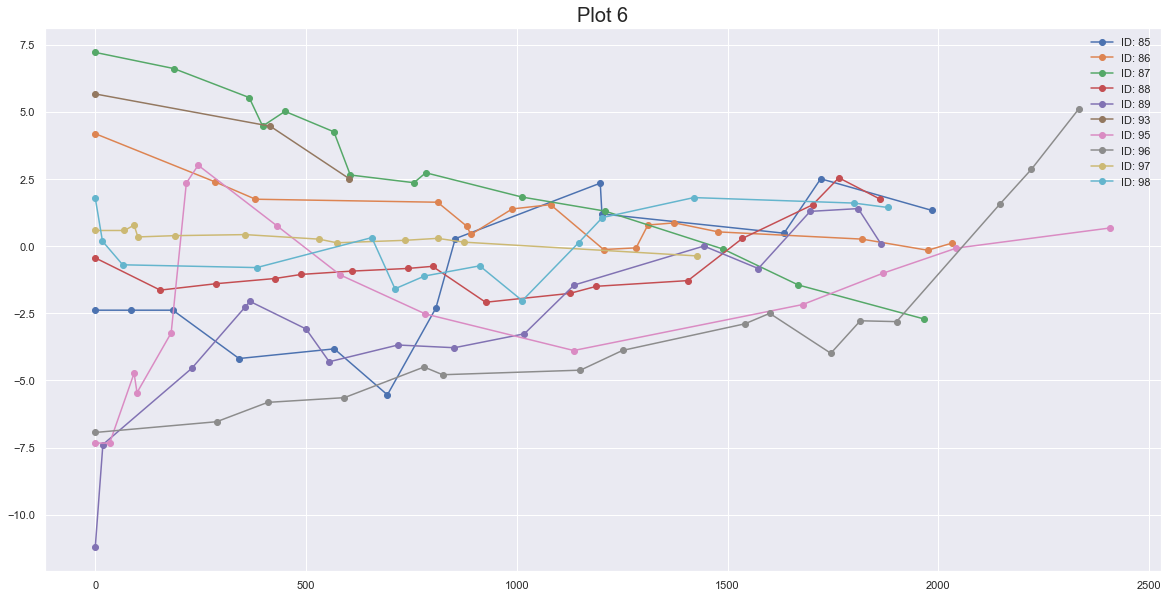

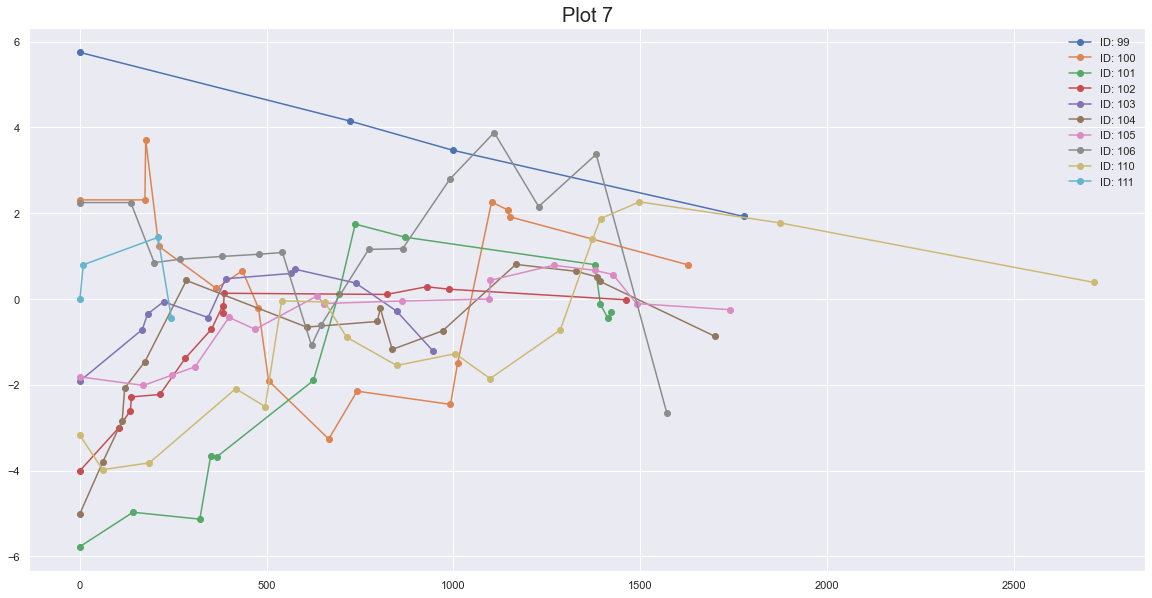

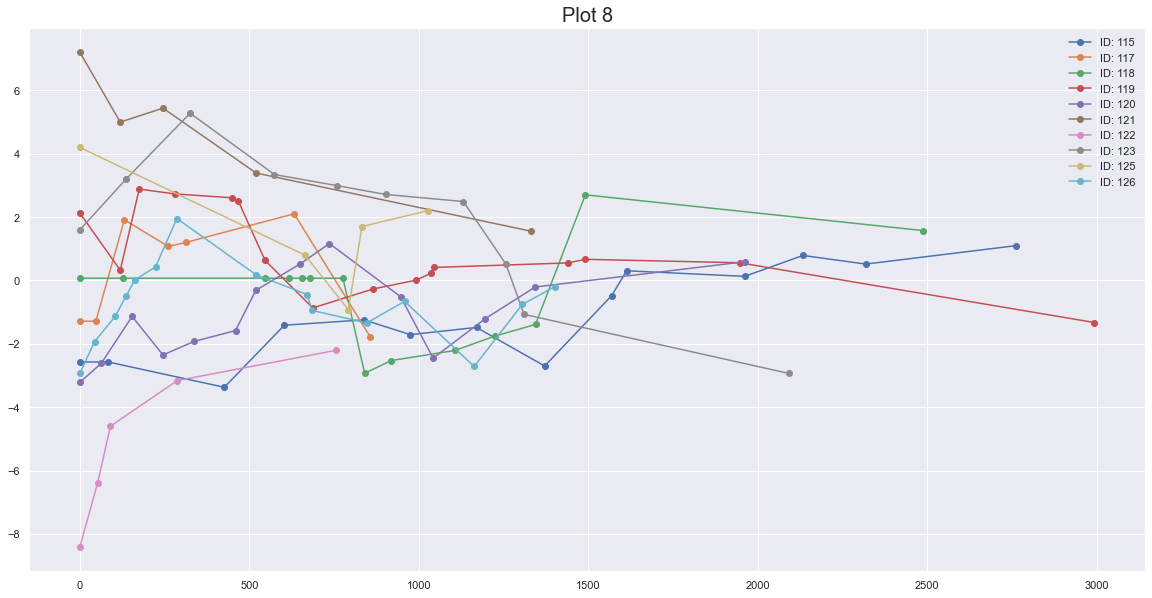

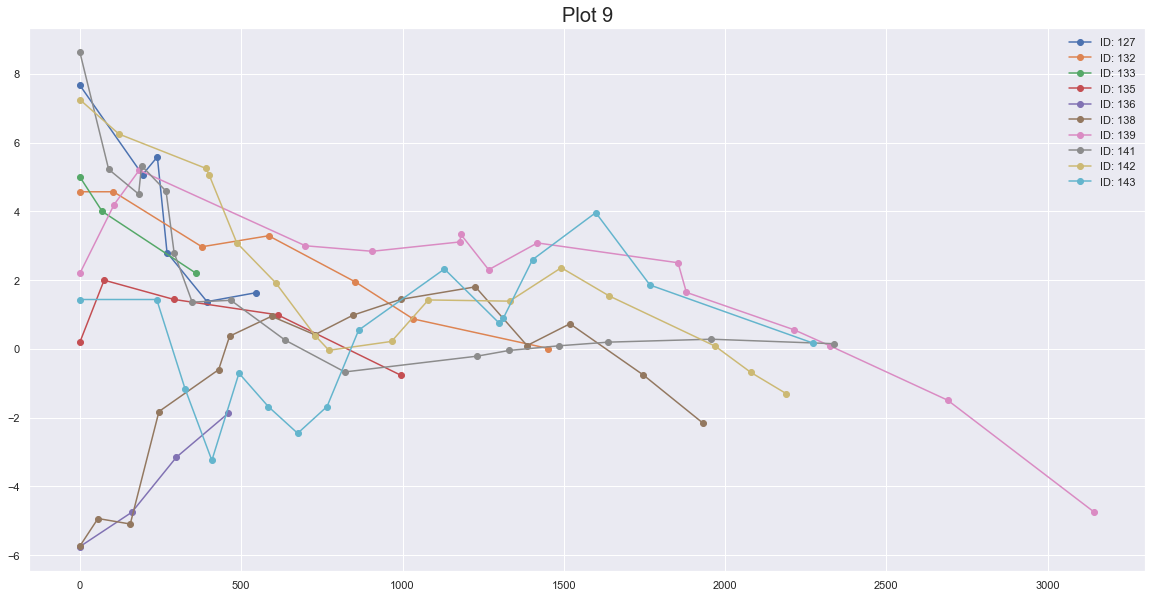

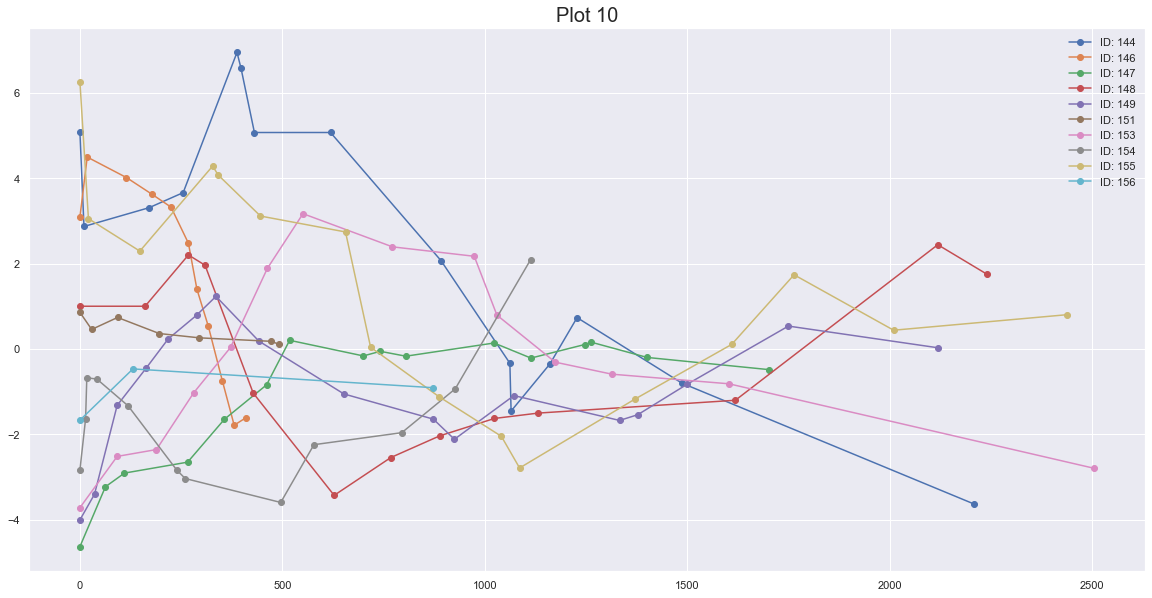

In [63]:
k_means_other_ind = np.where(k_means_labels == 0)[0]

for i in range(10, 110, 10):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ind = k_means_other_ind[i-10 : i]
    for j in range(10):
        x , y, idd = time_series[ind[j]] , egfr_series_smoothed[ind[j]], ind[j]
        ax.plot(x, y, '-o', label=f'ID: {idd}')
        ax.legend(frameon = False);
        plt.title(f'Plot {int(i/10)}', fontsize=20)

## Experimenting to see what would happen if we were to use a higher value of k in k-means clustering

In [64]:
kmm = TimeSeriesKMeans(n_clusters=4,
                           metric="dtw",
                           n_init=3,
                           verbose=False,
                           random_state=1, 
                           n_jobs=-1)
                           
k_means_labels2 = kmm.fit_predict(X_train)
k_means_ss2 = silhouette_score(X=dtw_distance_matrix, labels=k_means_labels2, metric='precomputed')
k_means_sil_vals2 = silhouette_samples(X=dtw_distance_matrix, labels=k_means_labels2, metric='precomputed')
print(f'Silhouette score using k-means: {k_means_ss2 :.3f}')

Silhouette score using k-means: 0.453


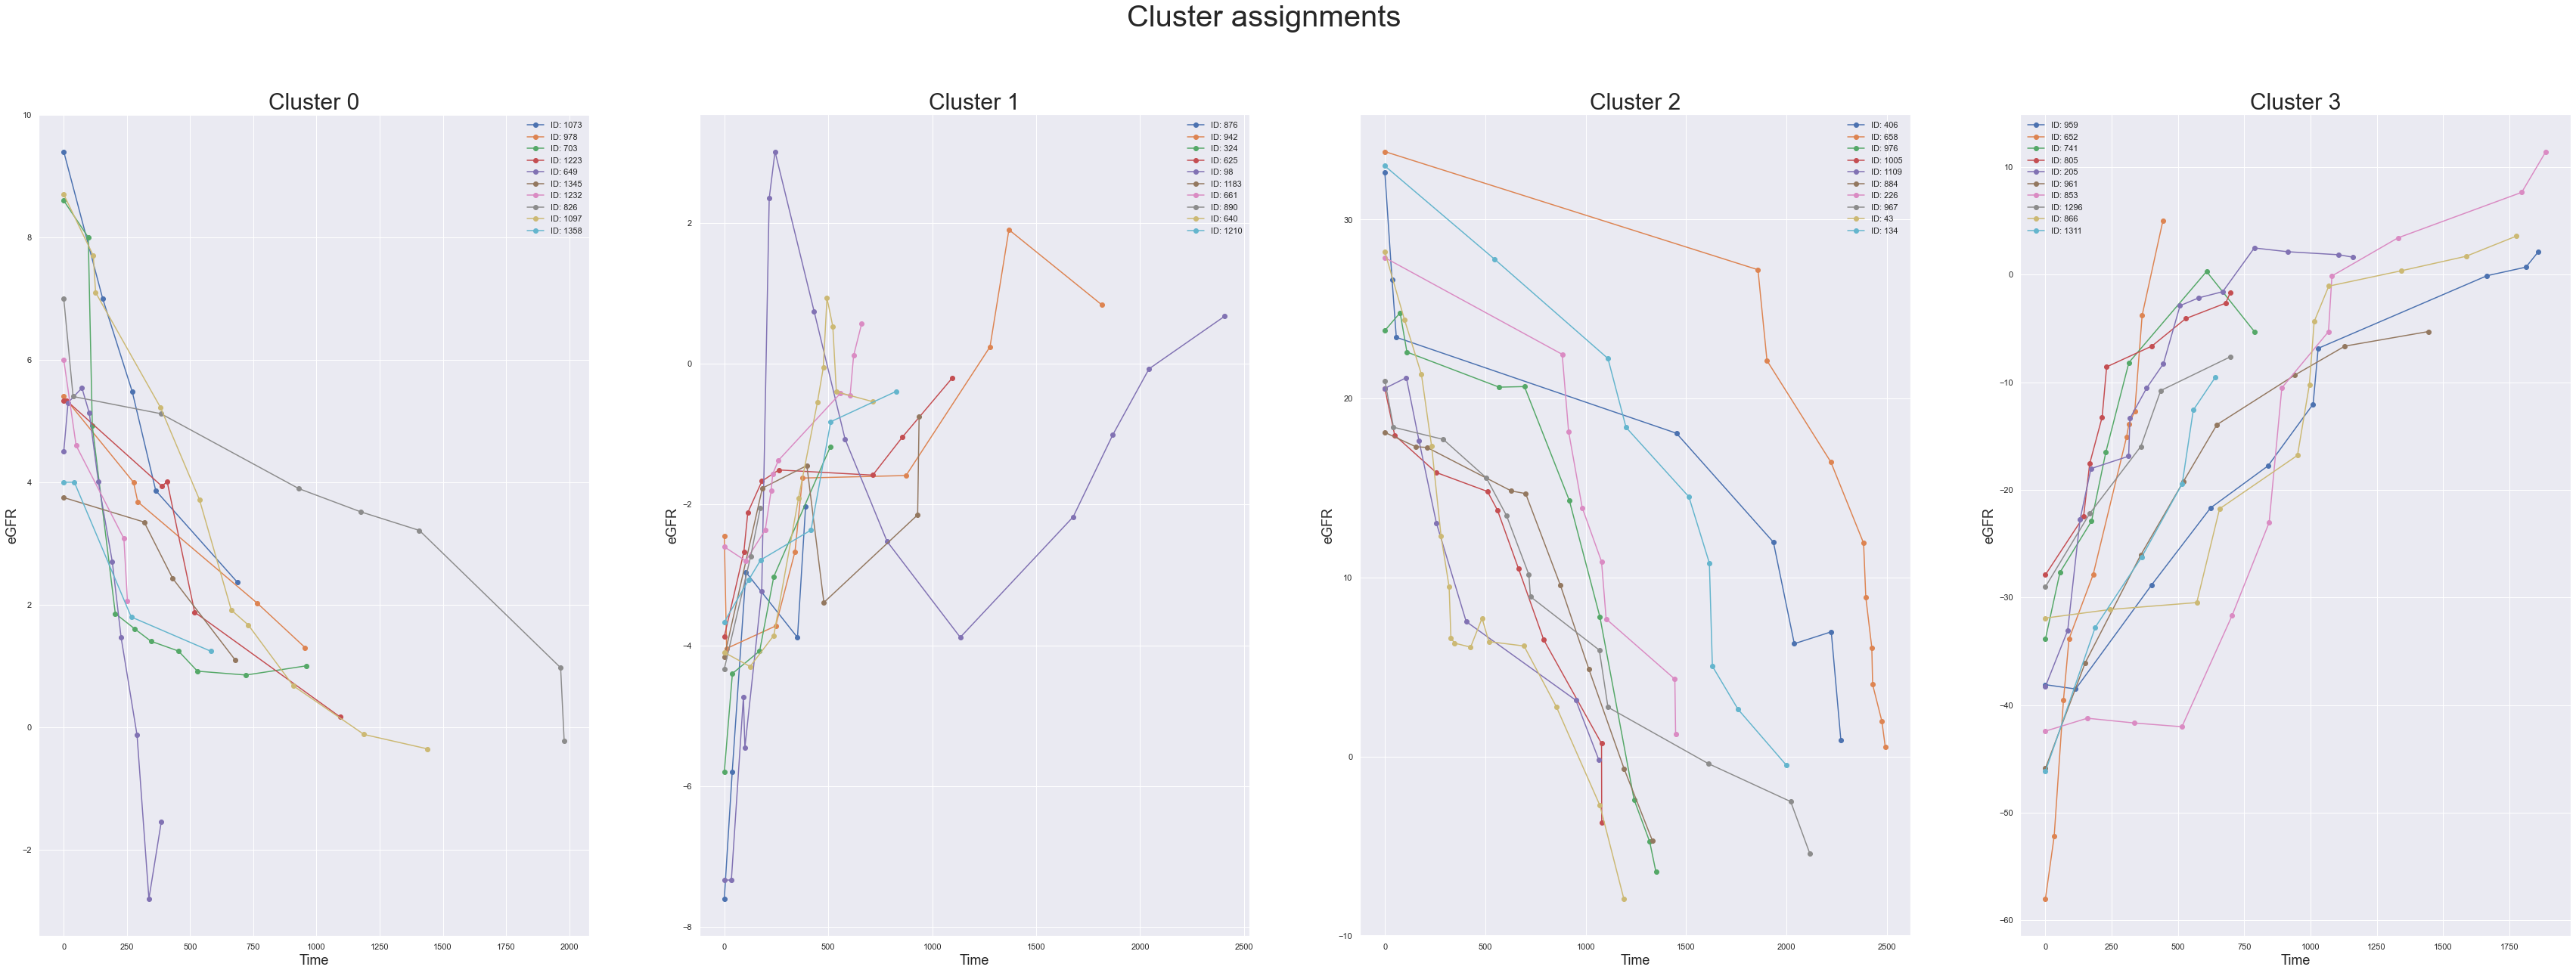

In [77]:
good_ind_k_means = np.where(silhouette_samples(X=dtw_distance_matrix, labels=k_means_labels2, metric='precomputed') > 0.50)[0] # indices of 'well' clustered data points

good_k_means_labels = k_means_labels2[good_ind_k_means]
good_id_k_means = [id[x] for x in good_ind_k_means]
good_time_series_k_means = [time_series[x] for x in good_ind_k_means]
good_egfr_series_k_means = [egfr_series[x] for x in good_ind_k_means]

# Let's plot the result
plot_subset_from_pred_clusters(good_k_means_labels, good_id_k_means, good_time_series_k_means, good_egfr_series_k_means, subset_size=10, seed=11, plot_smoothed=True, alpha=0.2)

We can see that both the Silhouette score decreases, but also that the clusters formed are much less interpretable. In particular, there seems to be a lot of overlap between clusters 0 and 2, which means that we cannot really distinguish the difference between them. Hence, we conclude that using k=3 clusters seems to be the right choice.

### Finally, let's assign the final labels to patients using the k-means algorithm with k=3.

In [33]:
assigned_labels = pd.DataFrame({'ID' : id, 'Label' : k_means_labels})
assigned_labels.to_csv('labelled_patients.csv')

In [35]:
assigned_labels

ID  Label
0        0      1
1        1      0
2        2      0
3        3      0
4        4      1
...    ...    ...
1205  1365      0
1206  1366      0
1207  1367      0
1208  1369      0
1209  1371      2

[1210 rows x 2 columns]